# Conclusion

XGBoost with kfolds=5, random oversampling, and pruned parameter values found with `RandomizedSearchCV`.

Good accuracy improvement from guessing. Slightly worse than when trained on team_v_team dataset.

## HOME_TEAM_WINS

Target to beat - 59.1% home winrate

Achieved - **65% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|59%|59%|58%|
|max_depth|65%|64%|63%|
|reg_lambda|60%|59%|59%|
|learning rate|61%|52%|49%|
|gamma|60%|58%|55%|
|scale_pos_weight|53%|51%|49%|

## HOME_HIGHER_FG_PCT

Target to beat - 55.0% rate of home having higher FGP

Achieved - **59% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|56%|55%|54%|
|max_depth|59%|57%|56%|
|reg_lambda|56%|56%|56%|
|learning rate|55%|52%|53%|
|gamma|56%|53%|48%|
|scale_pos_weight|51%|50%|48%|

## HOME_HIGHER_FG3_PCT

Target to beat - 50.8% rate of home having higher FG3

Achieved - **52% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|50%|50%|49%|
|max_depth|51%|51%|51%|
|reg_lambda|51%|50%|50%|
|learning rate|52%|50%|48%|
|gamma|49%|49%|48%|
|scale_pos_weight|51%|50%|49%|

## HOME_HIGHER_FT_PCT

Target to beat - 49.5% rate of home having higher FTP

Achieved - **52% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|52%|51%|51%|
|max_depth|51%|51%|51%|
|reg_lambda|51%|51%|50%|
|learning rate|51%|50%|49%|
|gamma|50%|50%|49%|
|scale_pos_weight|52%|50%|49%|

## HOME_HIGHER_AST

Target to beat - 55.0% rate of home having higher AST

Achieved - **59% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|56%|55%|55%|
|max_depth|59%|58%|57%|
|reg_lambda|56%|55%|55%|
|learning rate|57%|52%|49%|
|gamma|55%|55%|54%|
|scale_pos_weight|52%|50%|49%|

## HOME_HIGHER_REB

Target to beat - 53.4% rate of home having higher REB

Achieved - **55% accuracy**

|Pruning|Max Accuracy|Mean Accuracy|Min Accuracy|
|-|-|-|-|
|None|54%|54%|53%|
|max_depth|55%|55%|54%|
|reg_lambda|53%|53%|52%|
|learning rate|53%|50%|48%|
|gamma|54%|53%|53%|
|scale_pos_weight|52%|50%|50%|


In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from datasets import data as Local ## Local module to get dataframes

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
games_df, winners_df, greater_fgp_df, greater_fg3_df, greater_ft_df, greater_ast_df, greater_reb_df, cumulative_stats_df, games_details_df, teams_df, players_df, ranking_df = \
    Local.get_all_dataset_dataframes('../../datasets/')

# Target datasets

- Home has:
    - 59.1% Winrate
    - 55.0% Rate of Higher FGP
    - 50.8% Rate of Higher FG3
    - 49.5% Rate of Higher FTP
    - 55.0% Rate of Higher AST
    - 53.4% Rate of Higher REB

In [3]:
winners_df # Whether the home team won in a game in each row of `games_df`

16157    1
16156    1
16155    1
16154    1
16153    1
        ..
4        0
3        0
2        0
1        1
0        1
Name: HOME_TEAM_WINS, Length: 23520, dtype: int64

In [4]:
winners_df.describe()

count    23520.000000
mean         0.591029
std          0.491654
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_TEAM_WINS, dtype: float64

In [5]:
greater_fgp_df.describe()

count    23520.000000
mean         0.550468
std          0.497457
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FG_PCT, dtype: float64

In [6]:
greater_fg3_df.describe()

count    23520.000000
mean         0.507993
std          0.499947
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FG3_PCT, dtype: float64

In [7]:
greater_ft_df.describe()

count    23520.000000
mean         0.494855
std          0.499984
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FT_PCT, dtype: float64

In [8]:
greater_ast_df.describe()

count    23520.000000
mean         0.550128
std          0.497491
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_AST, dtype: float64

In [9]:
greater_reb_df.describe()

count    23520.000000
mean         0.533886
std          0.498861
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_REB, dtype: float64

# Datasets

In [10]:
games_df

GAME_DATE_EST   GAME_ID  HOME_TEAM_ID  VISITOR_TEAM_ID  SEASON  \
16157    2003-10-05  10300001    1610612762       1610612742    2003   
16156    2003-10-06  10300002    1610612763       1610612749    2003   
16155    2003-10-07  10300009    1610612758       1610612746    2003   
16154    2003-10-07  10300005    1610612757       1610612745    2003   
16153    2003-10-07  10300007    1610612748       1610612755    2003   
...             ...       ...           ...              ...     ...   
4        2020-12-18  12000040    1610612761       1610612748    2020   
3        2020-12-18  12000039    1610612754       1610612755    2020   
2        2020-12-19  12000049    1610612763       1610612737    2020   
1        2020-12-19  12000048    1610612764       1610612765    2020   
0        2020-12-19  12000047    1610612753       1610612766    2020   

       PTS_home  FG_PCT_home  FT_PCT_home  FG3_PCT_home  AST_home  REB_home  \
16157      90.0        0.457        0.735         0.143      23.0      41.0   
16156     105.0        0.494        0.618         0.267      25.0      48.0   
16155     101.0        0.467        0.871         0.444      19.0      39.0   
16154     104.0        0.527        0.657         0.429      22.0      33.0   
16153      86.0        0.352        0.647         0.222      15.0      55.0   
...         ...          ...          ...           ...       ...       ...   
4         105.0        0.380        0.737         0.356      27.0      37.0   
3         107.0        0.371        0.692         0.262      19.0      45.0   
2         116.0        0.400        0.744         0.396      21.0      43.0   
1          99.0        0.427        0.625         0.295      24.0      45.0   
0         120.0        0.433        0.792         0.425      23.0      50.0   

       PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  AST_away  REB_away  
16157      85.0        0.447        0.500         0.250      20.0      38.0  
16156      94.0        0.427        0.700         0.154      20.0      43.0  
16155      82.0        0.368        0.609         0.364      13.0      50.0  
16154      80.0        0.470        0.667         0.333      10.0      37.0  
16153      79.0        0.329        0.897         0.143       7.0      44.0  
...         ...          ...          ...           ...       ...       ...  
4         117.0        0.534        0.741         0.514      30.0      51.0  
3         113.0        0.533        0.629         0.355      23.0      48.0  
2         117.0        0.422        0.837         0.297      24.0      47.0  
1          96.0        0.402        0.647         0.326      18.0      51.0  
0         117.0        0.444        0.864         0.439      21.0      52.0  

[23520 rows x 17 columns]

In [11]:
cumulative_stats_df

DATE   GAME_ID  SEASON_TYPE  SEASON  GAMES_PLAYED_home  \
0      2003-10-05  10300001            1    2003                  0   
1      2003-10-06  10300002            1    2003                  0   
2      2003-10-07  10300009            1    2003                  0   
3      2003-10-07  10300005            1    2003                  0   
4      2003-10-07  10300007            1    2003                  0   
...           ...       ...          ...     ...                ...   
23515  2020-12-18  12000040            1    2020                  2   
23516  2020-12-18  12000039            1    2020                  2   
23517  2020-12-19  12000049            1    2020                  3   
23518  2020-12-19  12000048            1    2020                  2   
23519  2020-12-19  12000047            1    2020                  3   

       GAMES_PLAYED_away  PPG_total_home  FG_PCT_total_home  \
0                      0        0.000000           0.000000   
1                      0        0.000000           0.000000   
2                      0        0.000000           0.000000   
3                      0        0.000000           0.000000   
4                      0        0.000000           0.000000   
...                  ...             ...                ...   
23515                  1      111.500000           0.443500   
23516                  1      105.000000           0.438000   
23517                  3      119.333333           0.466667   
23518                  3      100.000000           0.415000   
23519                  3      112.666667           0.444333   

       FG3_PCT_total_home  FT_PCT_total_home  ...  PPG_total_away  \
0                0.000000           0.000000  ...        0.000000   
1                0.000000           0.000000  ...        0.000000   
2                0.000000           0.000000  ...        0.000000   
3                0.000000           0.000000  ...        0.000000   
4                0.000000           0.000000  ...        0.000000   
...                   ...                ...  ...             ...   
23515            0.353000           0.691000  ...       92.000000   
23516            0.383000           0.619000  ...      108.000000   
23517            0.329333           0.704667  ...      111.333333   
23518            0.321500           0.704500  ...       93.333333   
23519            0.305333           0.758000  ...      110.666667   

       FG_PCT_total_away  FG3_PCT_total_away  FT_PCT_total_away  \
0               0.000000            0.000000           0.000000   
1               0.000000            0.000000           0.000000   
2               0.000000            0.000000           0.000000   
3               0.000000            0.000000           0.000000   
4               0.000000            0.000000           0.000000   
...                  ...                 ...                ...   
23515           0.427000            0.283000           0.818000   
23516           0.471000            0.241000           0.750000   
23517           0.392667            0.332333           0.789667   
23518           0.413333            0.333000           0.713000   
23519           0.442333            0.372333           0.751000   

       APG_total_away  RPG_total_away  TEAM_ID_away  TEAM_ID_home  W_PCT_away  \
0            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
1            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
2            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
3            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
4            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
...               ...             ...           ...           ...         ...   
23515       26.000000       35.000000  1.610613e+09  1.610613e+09    0.000000   
23516       23.000000       42.000000  1.610613e+09  1.610613e+09    1.000000   
23517       24.000000       56.000000  1

## Attach target columns to dataset

In [12]:
cumulative_stats_copy_df = cumulative_stats_df.copy()
cumulative_stats_copy_df['home_win'] = winners_df
cumulative_stats_copy_df['greater_fgp'] = greater_fgp_df
cumulative_stats_copy_df['greater_fg3'] = greater_fg3_df
cumulative_stats_copy_df['greater_ft'] = greater_ft_df
cumulative_stats_copy_df['greater_ast'] = greater_ast_df
cumulative_stats_copy_df['greater_reb'] = greater_reb_df

## Remove rows w/o data

In [13]:
cumulative_stats_copy_df = cumulative_stats_copy_df[(cumulative_stats_copy_df['GAMES_PLAYED_home']>0) & (cumulative_stats_copy_df['GAMES_PLAYED_away']>0)]

# Get new target datasets after row removal
winners_df = cumulative_stats_copy_df['home_win']
greater_fgp_df = cumulative_stats_copy_df['greater_fgp']
greater_fg3_df = cumulative_stats_copy_df['greater_fg3']
greater_ft_df = cumulative_stats_copy_df['greater_ft']
greater_ast_df = cumulative_stats_copy_df['greater_ast']
greater_reb_df = cumulative_stats_copy_df['greater_reb']

## Remove non-data

In [14]:
# Delete non-data
for key in [
    'DATE','GAME_ID','TEAM_ID_home','TEAM_ID_away','SEASON_TYPE','SEASON','GAMES_PLAYED_home','GAMES_PLAYED_away',
    'home_win','greater_fgp','greater_fg3','greater_ft','greater_ast','greater_reb'
]:
    del cumulative_stats_copy_df[key]
# Only look at home teams
# cumulative_stats_copy_df = cumulative_stats_copy_df.loc[cumulative_stats_copy_df['AT_HOME']==True]
# del cumulative_stats_copy_df['AT_HOME']
cumulative_stats_copy_df

PPG_total_home  FG_PCT_total_home  FG3_PCT_total_home  \
19         104.000000           0.527000            0.429000   
21          86.000000           0.380000            0.188000   
22          86.000000           0.352000            0.222000   
23          58.000000           0.457000            0.667000   
24          87.500000           0.432000            0.420000   
...               ...                ...                 ...   
23515      111.500000           0.443500            0.353000   
23516      105.000000           0.438000            0.383000   
23517      119.333333           0.466667            0.329333   
23518      100.000000           0.415000            0.321500   
23519      112.666667           0.444333            0.305333   

       FT_PCT_total_home  APG_total_home  RPG_total_home  PPG_total_away  \
19              0.657000       22.000000       33.000000      101.000000   
21              0.852000       19.000000       37.000000      101.000000   
22              0.647000       15.000000       55.000000       80.000000   
23              0.700000       10.000000       31.000000       89.000000   
24              0.672000       20.500000       43.000000       79.000000   
...                  ...             ...             ...             ...   
23515           0.691000       25.000000       41.500000       92.000000   
23516           0.619000       26.000000       35.500000      108.000000   
23517           0.704667       30.666667       52.666667      111.333333   
23518           0.704500       22.000000       44.500000       93.333333   
23519           0.758000       25.000000       51.333333      110.666667   

       FG_PCT_total_away  FG3_PCT_total_away  FT_PCT_total_away  \
19              0.467000            0.444000           0.871000   
21              0.464000            0.250000           0.679000   
22              0.350000            0.429000           0.750000   
23              0.462000            0.214000           0.538000   
24              0.329000            0.143000           0.897000   
...                  ...                 ...                ...   
23515           0.427000            0.283000           0.818000   
23516           0.471000            0.241000           0.750000   
23517           0.392667            0.332333           0.789667   
23518           0.413333            0.333000           0.713000   
23519           0.442333            0.372333           0.751000   

       APG_total_away  RPG_total_away  W_PCT_away  W_PCT_home  
19          19.000000       39.000000    1.000000    1.000000  
21          22.000000       47.000000    1.000000    0.000000  
22          18.000000       45.000000    0.000000    1.000000  
23          21.000000       36.000000    0.000000    0.000000  
24           7.000000       44.000000    0.000000    0.500000  
...               ...             ...         ...         ...  
23515       26.000000       35.000000    0.000000    1.000000  
23516       23.000000       42.000000    1.000000    0.000000  
23517       24.000000       56.000000    0.333333    1.000000  
23518       20.000000       41.666667    0.666667    0.000000  
23519       29.666667       45.000000    0.333333    0.333333  

[23147 rows x 14 columns]

## Do hyperparameters searches

In [15]:
from sklearn.metrics import classification_report

In [16]:
from sklearn.tree import plot_tree
from yellowbrick.model_selection import FeatureImportances

In [17]:
from sklearn.utils.class_weight import compute_sample_weight

In [18]:
# Get best params based from CV function
def do_cv(classifier, cv_fun, params, x, y, **kwargs):
    clf = cv_fun(
        classifier,
        params,
        scoring='accuracy', # Optimize for the 'accuracy' score of the model.
        **kwargs,
    )
#     clf.fit(x, y, sample_weight=compute_sample_weight('balanced',y))
    clf.fit(x, y)
    return clf

## Plot feature importances

In [19]:
def plot_feature_importances(clf, X, y):
    viz = FeatureImportances(clf, labels=X.columns)
    viz.fit(X, y)
    viz.show()

In [20]:
def print_all_metrics_and_plot(clf, X_train_dict, X_test_dict, y_train_dict, y_test_dict, grid_cv_params):
    scores = []
    for key in X_train_dict.keys():
        cv_clf = do_cv(
            clf,
#             GridSearchCV,
            RandomizedSearchCV,
            grid_cv_params,
            X_train_dict[key],
            y_train_dict[key],
        )
        print(key.upper()+':\n')
        score = cv_clf.best_estimator_.score(X_test_dict[key], y_test_dict[key])
        scores.append(score)
        print('Best XGBoost accuracy (%s): %.2f' % (str(cv_clf.best_params_), score))
        print(classification_report(y_test_dict[key], cv_clf.best_estimator_.predict(X_test_dict[key])))
        plot_feature_importances(cv_clf.best_estimator_, X_train_dict[key], y_train_dict[key])
        print('---------------------------------------------')
    return scores

## Build K-folds datasets

In [21]:
from imblearn.over_sampling import RandomOverSampler

In [22]:
from sklearn.model_selection import KFold
kf = KFold(shuffle=True, random_state=123)

X_train_dicts = []
X_test_dicts = []
y_train_dicts = []
y_test_dicts = []

for target, key in [(winners_df, 'winner'), (greater_fgp_df, 'fgp'), (greater_fg3_df, 'fg3'), (greater_ft_df, 'ft'), (greater_ast_df, 'ast'), (greater_reb_df, 'reb')]:
    X_over, y_over = RandomOverSampler(sampling_strategy='minority').fit_resample(cumulative_stats_copy_df, target)
    for train, test in kf.split(X_over, y_over):
        X_train_dict = {}
        X_test_dict = {}
        y_train_dict = {}
        y_test_dict = {}
        
        X_train_dict[key], X_test_dict[key] = X_over.iloc[train], X_over.iloc[test]
        y_train_dict[key], y_test_dict[key] = y_over.iloc[train], y_over.iloc[test]
        
        X_train_dicts.append(X_train_dict)
        X_test_dicts.append(X_test_dict)
        y_train_dicts.append(y_train_dict)
        y_test_dicts.append(y_test_dict)

assert len(X_train_dicts)==len(X_test_dicts)==len(y_train_dicts)==len(y_test_dicts)
print(len(X_train_dicts))

30


In [23]:
def print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, params):
    scores=[]
    for i in range(len(X_train_dicts)):
        print(f'i={i}')
        score = print_all_metrics_and_plot(
            xgb.XGBClassifier(random_state=0,eval_metric='logloss'),
            X_train_dicts[i],
            X_test_dicts[i],
            y_train_dicts[i],
            y_test_dicts[i],
            params,
        )
        if (i+1)%5==0:
            scores = pd.DataFrame(np.array(scores))
            print(f'Mean accuracy: {scores.mean()[0]}')
            print(f'Max accuracy: {scores.max()[0]}')
            print(f'Min accuracy: {scores.min()[0]}')
            print('=========================================')
            scores=[]
        else:
            scores += score

## Train w/o pruning

In [24]:
import warnings
warnings.filterwarnings("ignore")

i=0
WINNER:

Best XGBoost accuracy ({}): 0.60
              precision    recall  f1-score   support

           0       0.58      0.64      0.61      2695
           1       0.61      0.56      0.59      2789

    accuracy                           0.60      5484
   macro avg       0.60      0.60      0.60      5484
weighted avg       0.60      0.60      0.60      5484



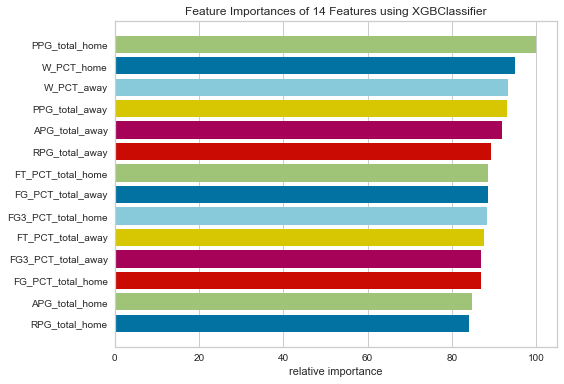

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({}): 0.59
              precision    recall  f1-score   support

           0       0.59      0.61      0.60      2780
           1       0.59      0.57      0.58      2704

    accuracy                           0.59      5484
   macro avg       0.59      0.59      0.59      5484
weighted avg       0.59      0.59      0.59      5484



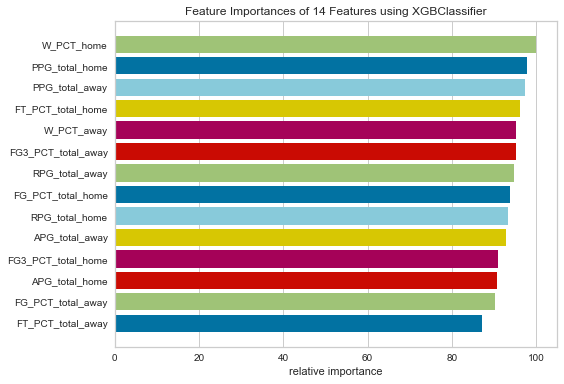

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({}): 0.59
              precision    recall  f1-score   support

           0       0.58      0.60      0.59      2727
           1       0.59      0.58      0.58      2757

    accuracy                           0.59      5484
   macro avg       0.59      0.59      0.59      5484
weighted avg       0.59      0.59      0.59      5484



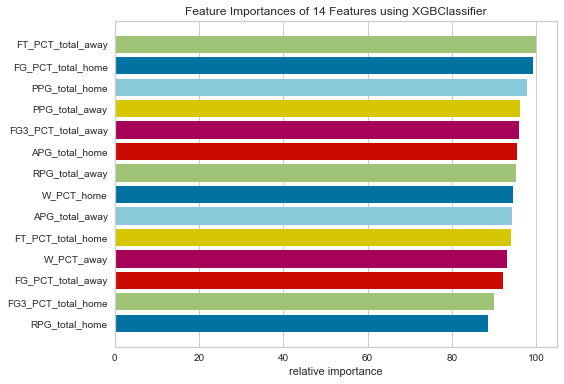

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({}): 0.59
              precision    recall  f1-score   support

           0       0.58      0.61      0.60      2715
           1       0.60      0.58      0.59      2768

    accuracy                           0.59      5483
   macro avg       0.59      0.59      0.59      5483
weighted avg       0.59      0.59      0.59      5483



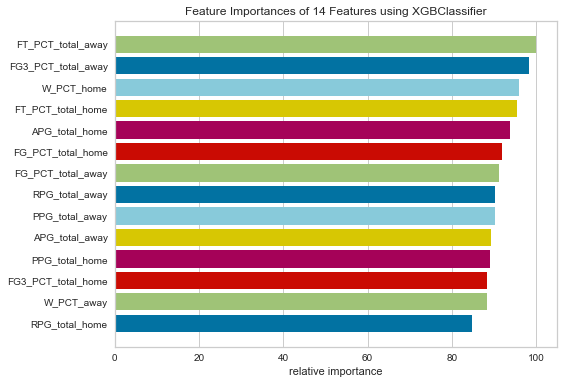

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({}): 0.61
              precision    recall  f1-score   support

           0       0.61      0.63      0.62      2792
           1       0.60      0.58      0.59      2691

    accuracy                           0.61      5483
   macro avg       0.61      0.61      0.61      5483
weighted avg       0.61      0.61      0.61      5483



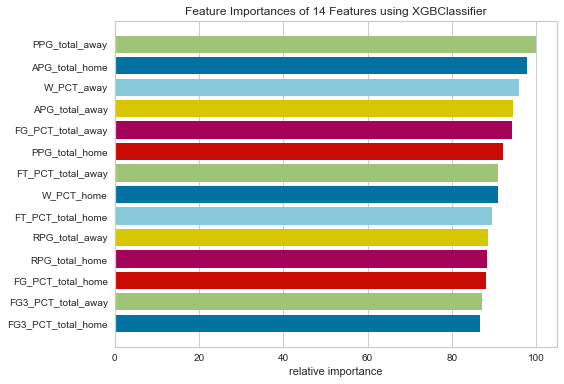

---------------------------------------------
Mean accuracy: 0.5916571684404006
Max accuracy: 0.5966447848285923
Min accuracy: 0.5886214442013129
i=5
FGP:

Best XGBoost accuracy ({}): 0.56
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      2614
           1       0.55      0.55      0.55      2495

    accuracy                           0.56      5109
   macro avg       0.56      0.56      0.56      5109
weighted avg       0.56      0.56      0.56      5109



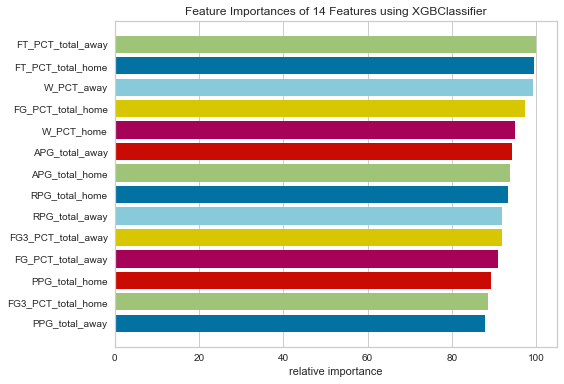

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.56      0.55      2571
           1       0.55      0.54      0.54      2538

    accuracy                           0.55      5109
   macro avg       0.55      0.55      0.55      5109
weighted avg       0.55      0.55      0.55      5109



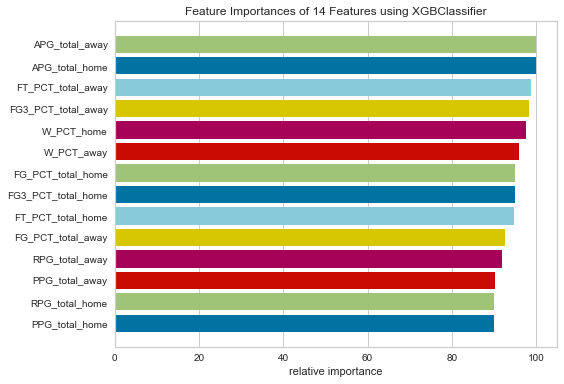

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({}): 0.56
              precision    recall  f1-score   support

           0       0.56      0.58      0.57      2559
           1       0.57      0.54      0.55      2549

    accuracy                           0.56      5108
   macro avg       0.56      0.56      0.56      5108
weighted avg       0.56      0.56      0.56      5108



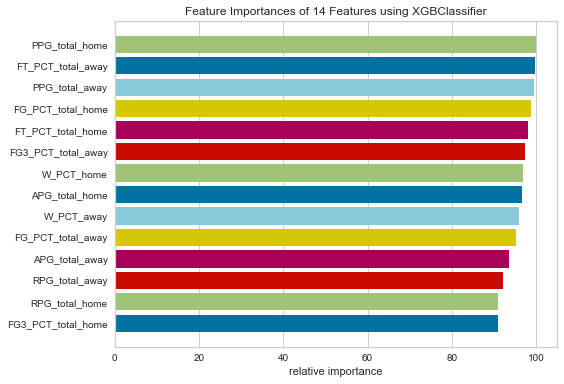

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({}): 0.55
              precision    recall  f1-score   support

           0       0.53      0.57      0.55      2470
           1       0.57      0.52      0.54      2638

    accuracy                           0.55      5108
   macro avg       0.55      0.55      0.55      5108
weighted avg       0.55      0.55      0.55      5108



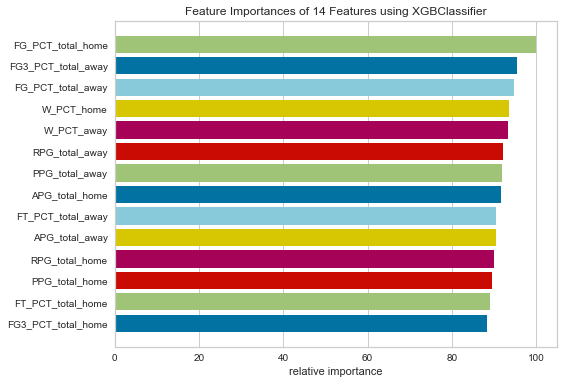

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.56      0.56      2557
           1       0.55      0.54      0.55      2551

    accuracy                           0.55      5108
   macro avg       0.55      0.55      0.55      5108
weighted avg       0.55      0.55      0.55      5108



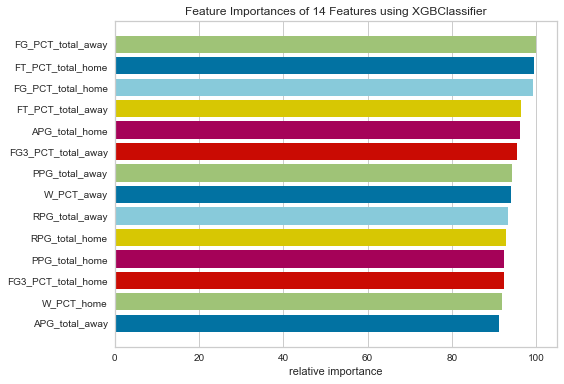

---------------------------------------------
Mean accuracy: 0.5556915334203019
Max accuracy: 0.5640172278778387
Min accuracy: 0.548159749412686
i=10
FG3:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.50      0.51      2365
           1       0.50      0.51      0.51      2346

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



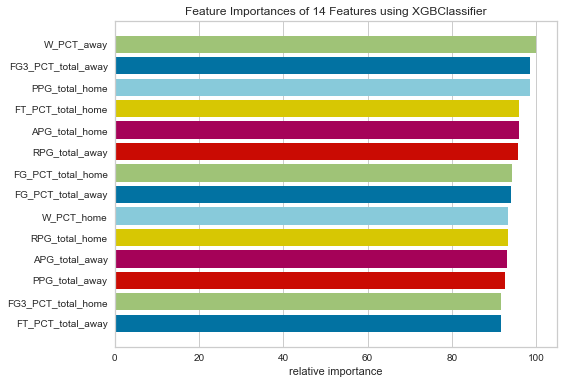

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2402
           1       0.49      0.50      0.50      2309

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.50      0.50      0.50      4711



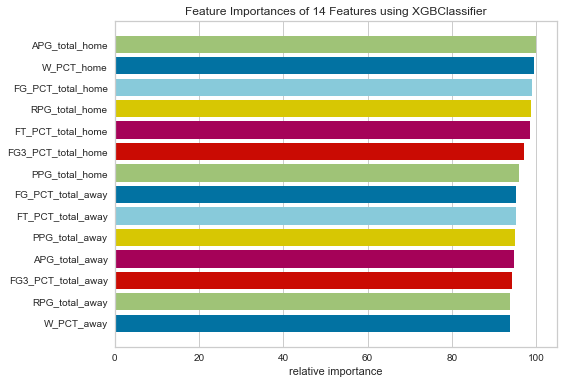

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({}): 0.50
              precision    recall  f1-score   support

           0       0.48      0.51      0.50      2284
           1       0.51      0.48      0.49      2427

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.50      0.50      0.50      4711



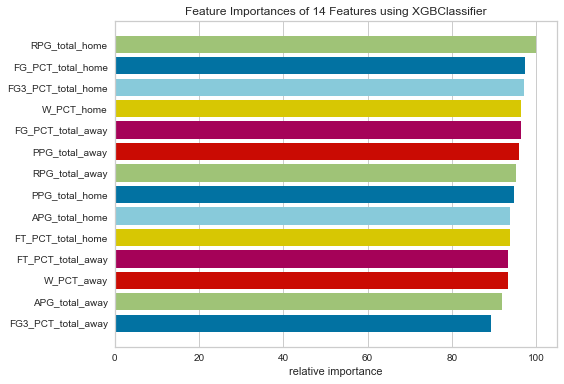

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      2307
           1       0.52      0.50      0.51      2404

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



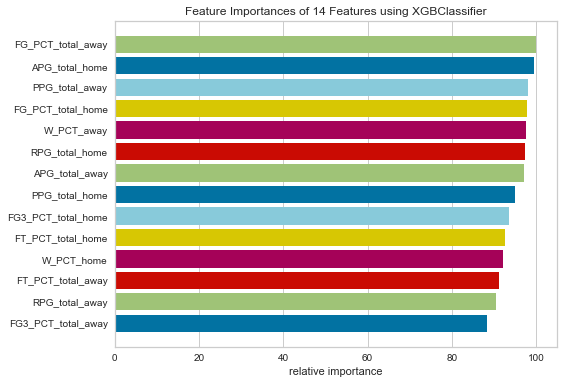

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      2419
           1       0.50      0.51      0.50      2291

    accuracy                           0.51      4710
   macro avg       0.51      0.51      0.51      4710
weighted avg       0.51      0.51      0.51      4710



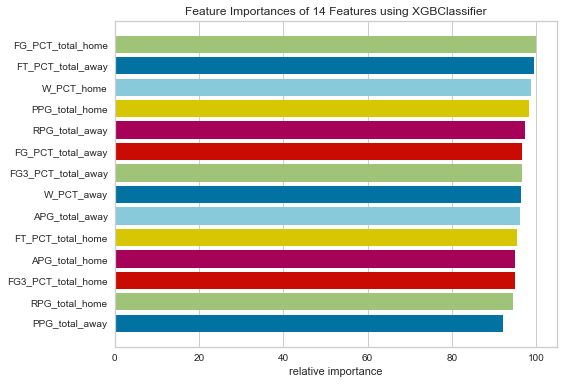

---------------------------------------------
Mean accuracy: 0.5040331139885375
Max accuracy: 0.5096582466567607
Min accuracy: 0.4952239439609425
i=15
FT:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2337
           1       0.52      0.53      0.53      2345

    accuracy                           0.52      4682
   macro avg       0.52      0.52      0.52      4682
weighted avg       0.52      0.52      0.52      4682



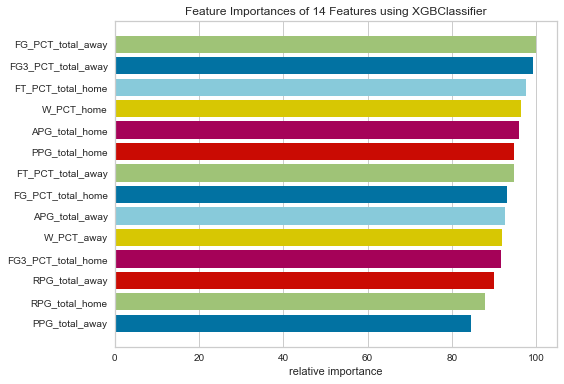

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      2322
           1       0.52      0.50      0.51      2360

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



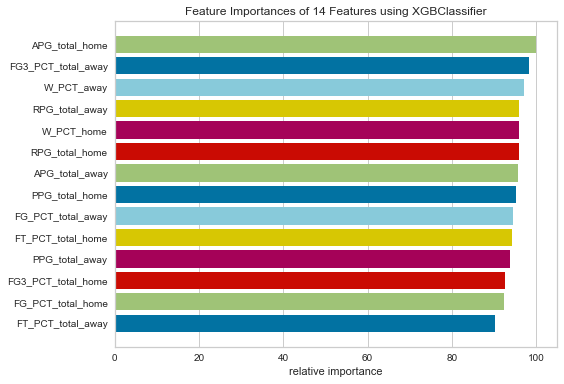

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2360
           1       0.51      0.52      0.52      2322

    accuracy                           0.52      4682
   macro avg       0.52      0.52      0.52      4682
weighted avg       0.52      0.52      0.52      4682



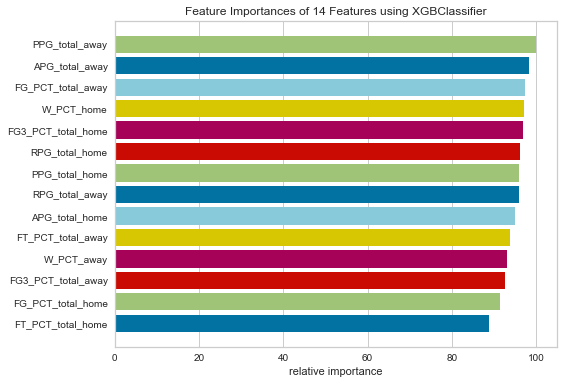

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      2343
           1       0.52      0.52      0.52      2339

    accuracy                           0.52      4682
   macro avg       0.52      0.52      0.52      4682
weighted avg       0.52      0.52      0.52      4682



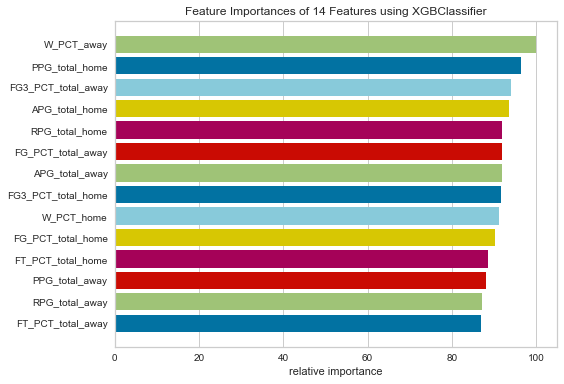

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      2343
           1       0.52      0.51      0.52      2339

    accuracy                           0.52      4682
   macro avg       0.52      0.52      0.52      4682
weighted avg       0.52      0.52      0.52      4682



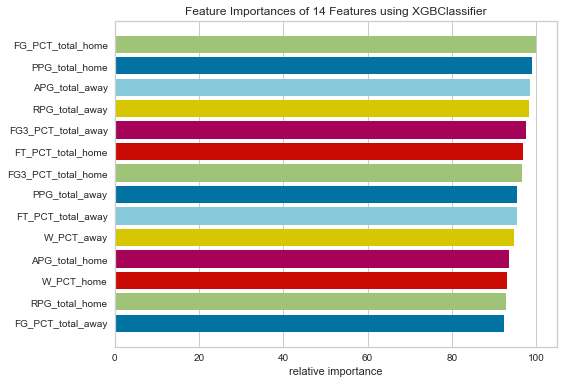

---------------------------------------------
Mean accuracy: 0.5185284066638188
Max accuracy: 0.5237078171721486
Min accuracy: 0.5138829560017086
i=20
AST:

Best XGBoost accuracy ({}): 0.56
              precision    recall  f1-score   support

           0       0.56      0.58      0.57      2556
           1       0.56      0.55      0.55      2540

    accuracy                           0.56      5096
   macro avg       0.56      0.56      0.56      5096
weighted avg       0.56      0.56      0.56      5096



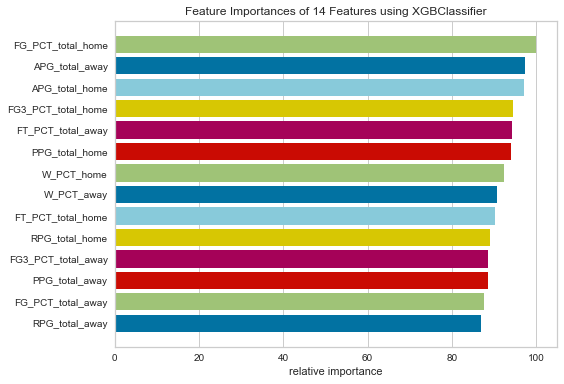

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({}): 0.56
              precision    recall  f1-score   support

           0       0.56      0.57      0.56      2578
           1       0.55      0.55      0.55      2517

    accuracy                           0.56      5095
   macro avg       0.56      0.56      0.56      5095
weighted avg       0.56      0.56      0.56      5095



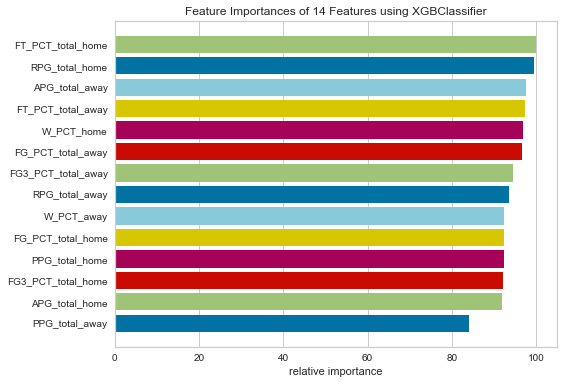

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({}): 0.56
              precision    recall  f1-score   support

           0       0.55      0.58      0.57      2522
           1       0.57      0.53      0.55      2573

    accuracy                           0.56      5095
   macro avg       0.56      0.56      0.56      5095
weighted avg       0.56      0.56      0.56      5095



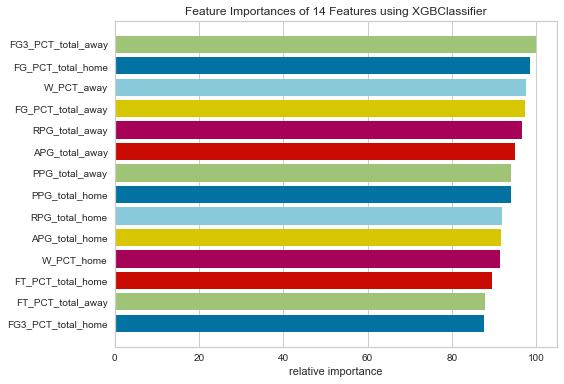

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({}): 0.56
              precision    recall  f1-score   support

           0       0.56      0.57      0.56      2531
           1       0.57      0.55      0.56      2564

    accuracy                           0.56      5095
   macro avg       0.56      0.56      0.56      5095
weighted avg       0.56      0.56      0.56      5095



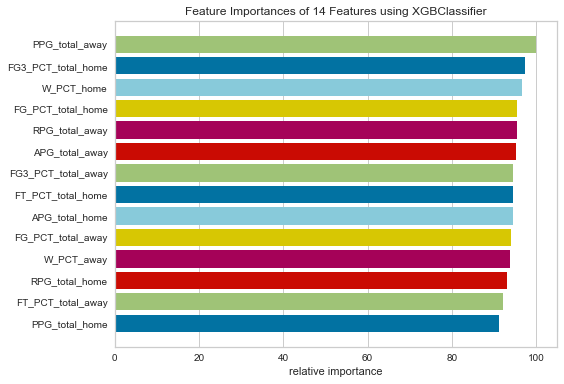

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      2551
           1       0.56      0.54      0.55      2544

    accuracy                           0.55      5095
   macro avg       0.55      0.55      0.55      5095
weighted avg       0.55      0.55      0.55      5095



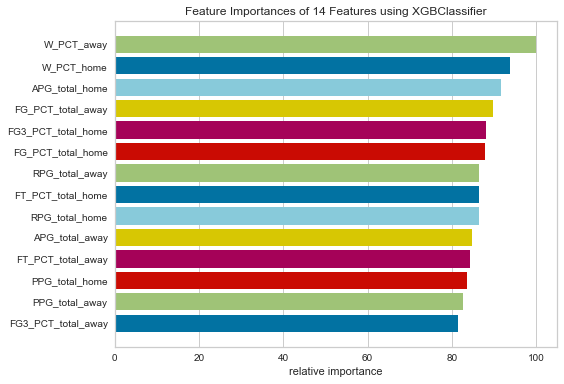

---------------------------------------------
Mean accuracy: 0.5593444145228107
Max accuracy: 0.5608320251177394
Min accuracy: 0.5572129538763494
i=25
REB:

Best XGBoost accuracy ({}): 0.55
              precision    recall  f1-score   support

           0       0.54      0.57      0.56      2470
           1       0.55      0.52      0.53      2475

    accuracy                           0.55      4945
   macro avg       0.55      0.55      0.55      4945
weighted avg       0.55      0.55      0.55      4945



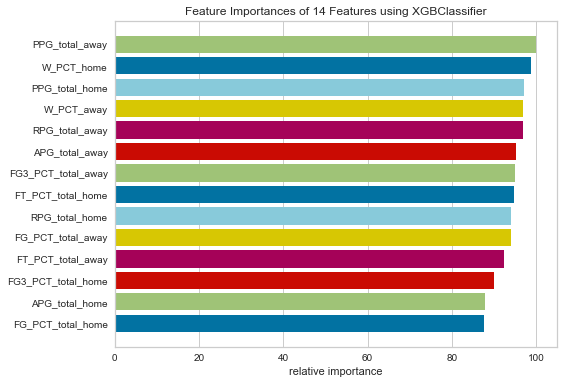

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({}): 0.55
              precision    recall  f1-score   support

           0       0.53      0.57      0.55      2413
           1       0.56      0.53      0.54      2532

    accuracy                           0.55      4945
   macro avg       0.55      0.55      0.55      4945
weighted avg       0.55      0.55      0.55      4945



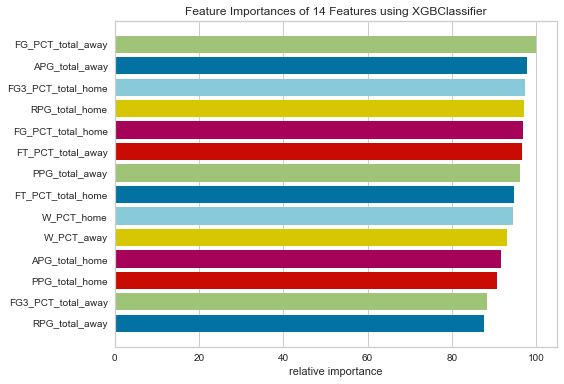

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.56      0.55      2479
           1       0.54      0.53      0.53      2465

    accuracy                           0.54      4944
   macro avg       0.54      0.54      0.54      4944
weighted avg       0.54      0.54      0.54      4944



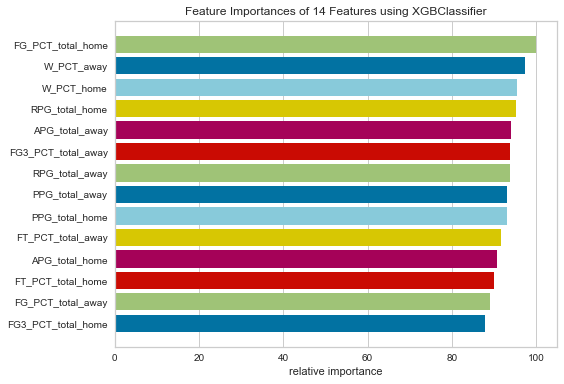

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.54      0.54      2473
           1       0.53      0.53      0.53      2471

    accuracy                           0.53      4944
   macro avg       0.53      0.53      0.53      4944
weighted avg       0.53      0.53      0.53      4944



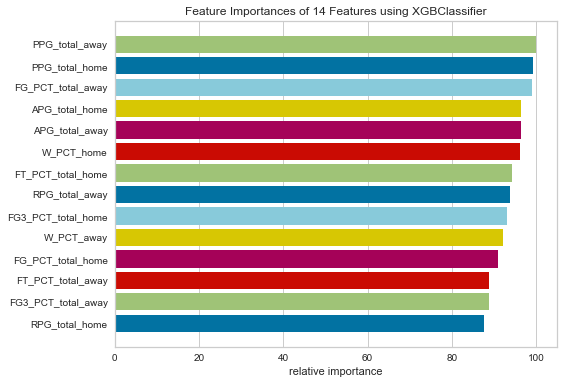

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({}): 0.53
              precision    recall  f1-score   support

           0       0.54      0.51      0.53      2526
           1       0.52      0.55      0.53      2418

    accuracy                           0.53      4944
   macro avg       0.53      0.53      0.53      4944
weighted avg       0.53      0.53      0.53      4944



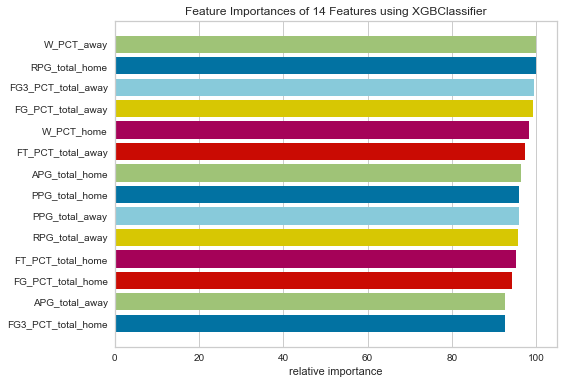

---------------------------------------------
Mean accuracy: 0.5418642690959781
Max accuracy: 0.5468149646107179
Min accuracy: 0.5327669902912622


In [28]:
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {})

## Try prune max depth

i=0
WINNER:

Best XGBoost accuracy ({'max_depth': 12}): 0.65
              precision    recall  f1-score   support

           0       0.64      0.67      0.65      2695
           1       0.66      0.63      0.65      2789

    accuracy                           0.65      5484
   macro avg       0.65      0.65      0.65      5484
weighted avg       0.65      0.65      0.65      5484



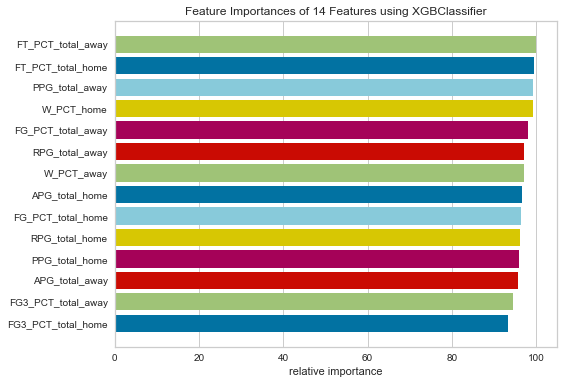

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'max_depth': 14}): 0.66
              precision    recall  f1-score   support

           0       0.66      0.67      0.67      2780
           1       0.66      0.64      0.65      2704

    accuracy                           0.66      5484
   macro avg       0.66      0.66      0.66      5484
weighted avg       0.66      0.66      0.66      5484



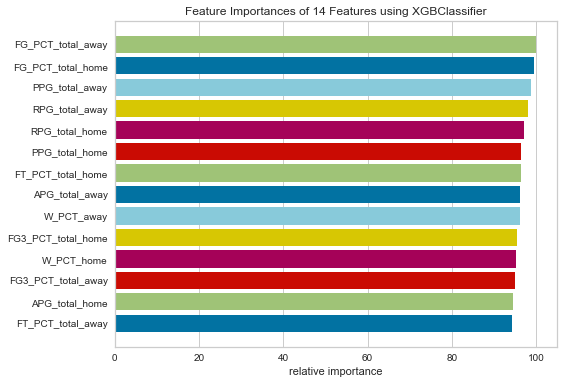

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'max_depth': 9}): 0.63
              precision    recall  f1-score   support

           0       0.62      0.67      0.65      2727
           1       0.65      0.59      0.62      2757

    accuracy                           0.63      5484
   macro avg       0.63      0.63      0.63      5484
weighted avg       0.63      0.63      0.63      5484



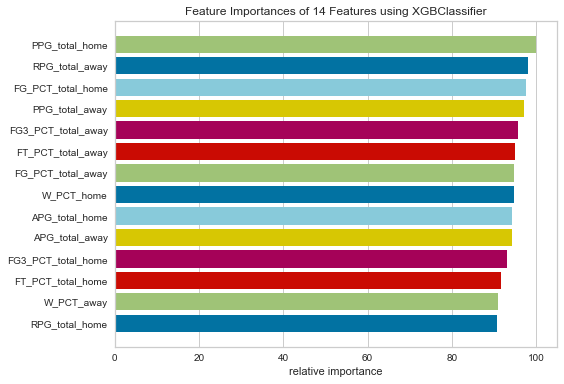

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'max_depth': 10}): 0.65
              precision    recall  f1-score   support

           0       0.64      0.67      0.65      2715
           1       0.66      0.63      0.64      2768

    accuracy                           0.65      5483
   macro avg       0.65      0.65      0.65      5483
weighted avg       0.65      0.65      0.65      5483



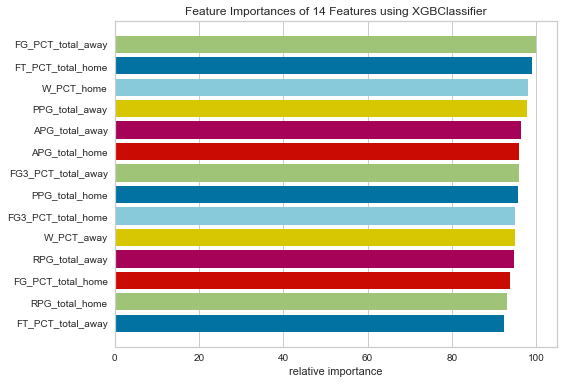

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'max_depth': 12}): 0.65
              precision    recall  f1-score   support

           0       0.65      0.66      0.66      2792
           1       0.64      0.64      0.64      2691

    accuracy                           0.65      5483
   macro avg       0.65      0.65      0.65      5483
weighted avg       0.65      0.65      0.65      5483



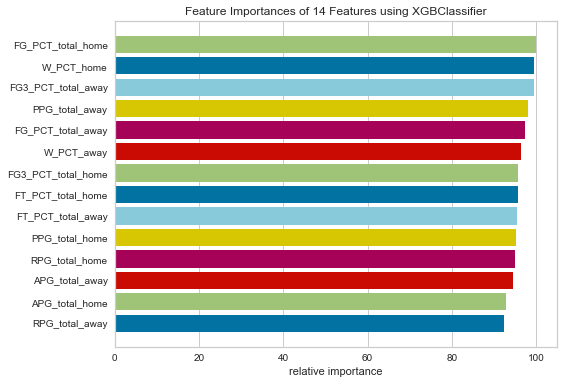

---------------------------------------------
Mean accuracy: 0.6476408481197702
Max accuracy: 0.6579139314369074
Min accuracy: 0.6336615609044494
i=5
FGP:

Best XGBoost accuracy ({'max_depth': 8}): 0.59
              precision    recall  f1-score   support

           0       0.60      0.60      0.60      2614
           1       0.58      0.58      0.58      2495

    accuracy                           0.59      5109
   macro avg       0.59      0.59      0.59      5109
weighted avg       0.59      0.59      0.59      5109



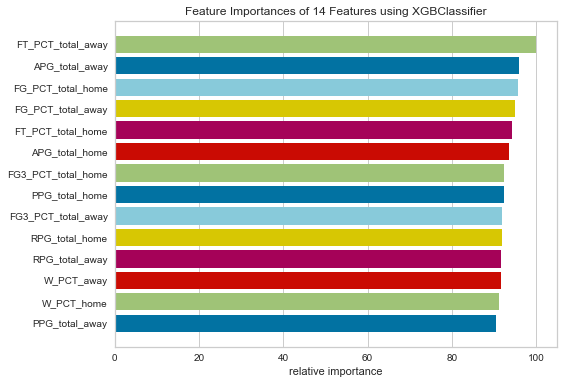

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'max_depth': 13}): 0.58
              precision    recall  f1-score   support

           0       0.58      0.59      0.59      2571
           1       0.58      0.57      0.57      2538

    accuracy                           0.58      5109
   macro avg       0.58      0.58      0.58      5109
weighted avg       0.58      0.58      0.58      5109



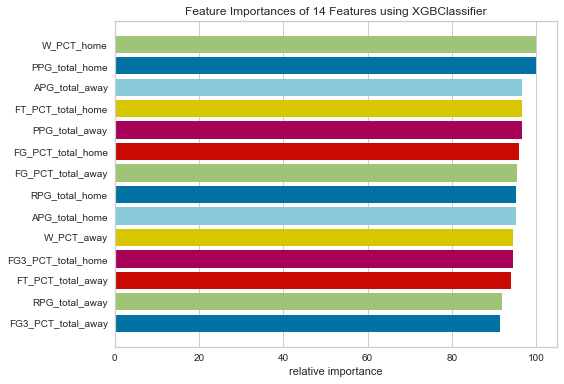

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'max_depth': 10}): 0.58
              precision    recall  f1-score   support

           0       0.58      0.59      0.59      2559
           1       0.58      0.57      0.57      2549

    accuracy                           0.58      5108
   macro avg       0.58      0.58      0.58      5108
weighted avg       0.58      0.58      0.58      5108



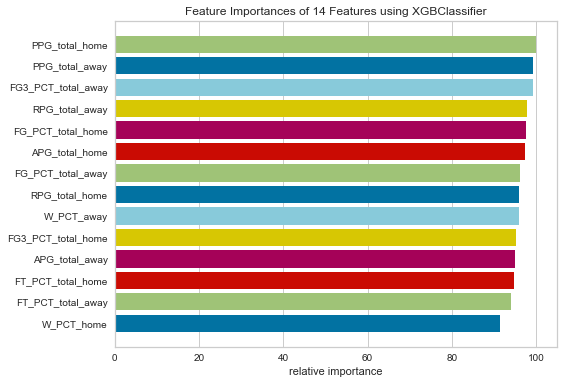

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'max_depth': 9}): 0.57
              precision    recall  f1-score   support

           0       0.55      0.59      0.57      2470
           1       0.59      0.54      0.56      2638

    accuracy                           0.57      5108
   macro avg       0.57      0.57      0.57      5108
weighted avg       0.57      0.57      0.57      5108



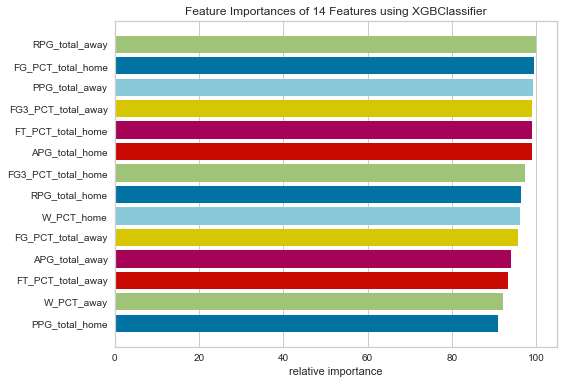

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'max_depth': 9}): 0.59
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      2557
           1       0.59      0.59      0.59      2551

    accuracy                           0.59      5108
   macro avg       0.59      0.59      0.59      5108
weighted avg       0.59      0.59      0.59      5108



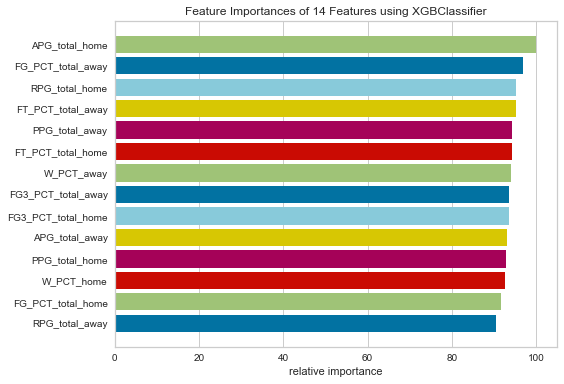

---------------------------------------------
Mean accuracy: 0.5791810860745537
Max accuracy: 0.5915051869250343
Min accuracy: 0.5655833985904464
i=10
FG3:

Best XGBoost accuracy ({'max_depth': 10}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      2365
           1       0.51      0.52      0.52      2346

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



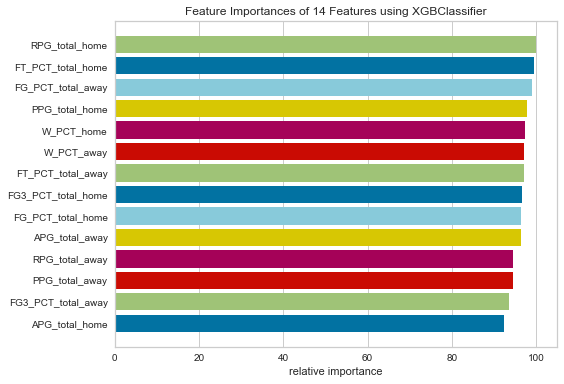

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'max_depth': 7}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.53      0.53      2402
           1       0.51      0.50      0.50      2309

    accuracy                           0.52      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.52      0.52      0.52      4711



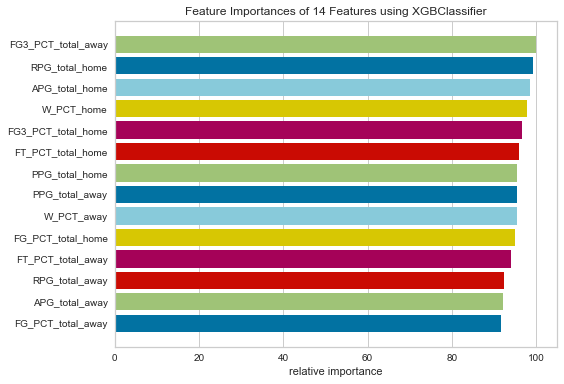

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'max_depth': 14}): 0.52
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      2284
           1       0.53      0.51      0.52      2427

    accuracy                           0.52      4711
   macro avg       0.52      0.52      0.52      4711
weighted avg       0.52      0.52      0.52      4711



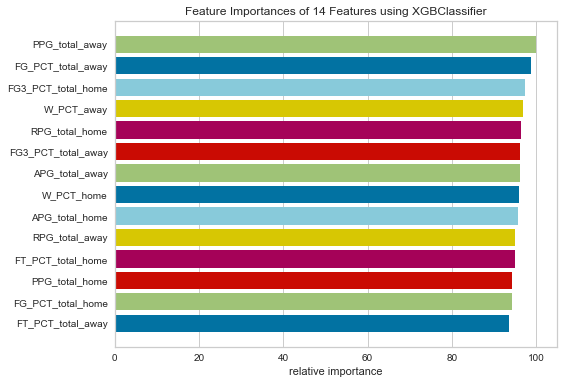

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'max_depth': 6}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      2307
           1       0.52      0.51      0.52      2404

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



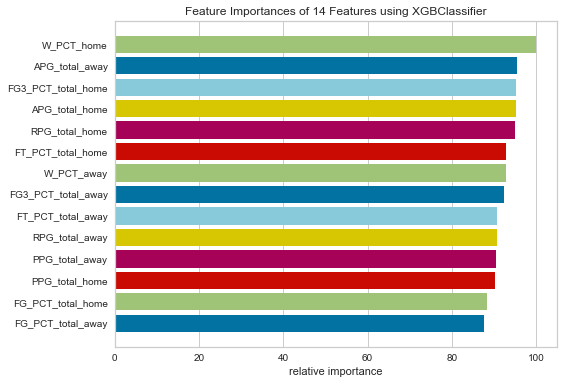

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'max_depth': 5}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      2419
           1       0.50      0.51      0.50      2291

    accuracy                           0.51      4710
   macro avg       0.51      0.51      0.51      4710
weighted avg       0.51      0.51      0.51      4710



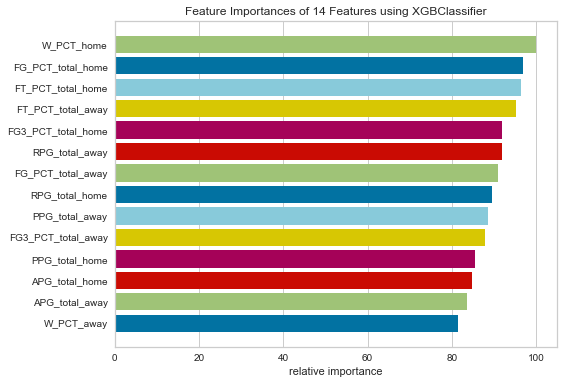

---------------------------------------------
Mean accuracy: 0.5155487157715983
Max accuracy: 0.5183612821057101
Min accuracy: 0.5139036298025896
i=15
FT:

Best XGBoost accuracy ({'max_depth': 17}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2337
           1       0.52      0.52      0.52      2345

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



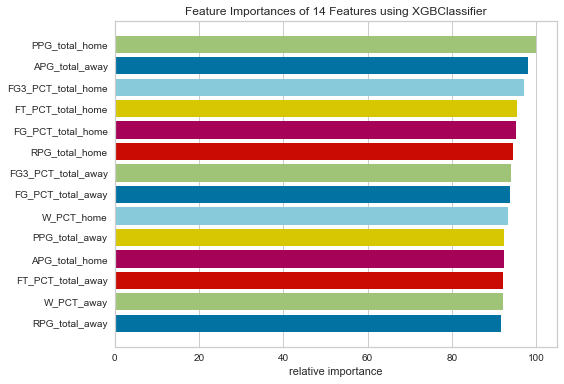

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'max_depth': 6}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.52      0.51      2322
           1       0.52      0.51      0.51      2360

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



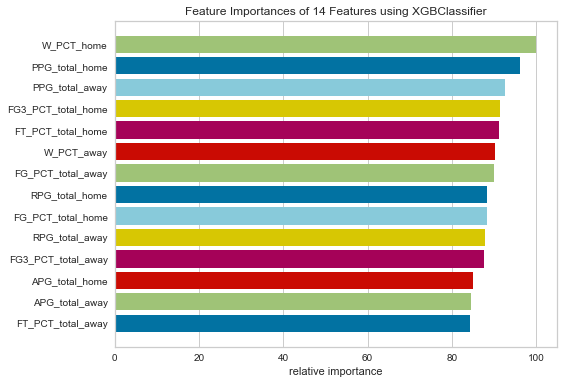

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'max_depth': 11}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2360
           1       0.51      0.51      0.51      2322

    accuracy                           0.52      4682
   macro avg       0.52      0.52      0.52      4682
weighted avg       0.52      0.52      0.52      4682



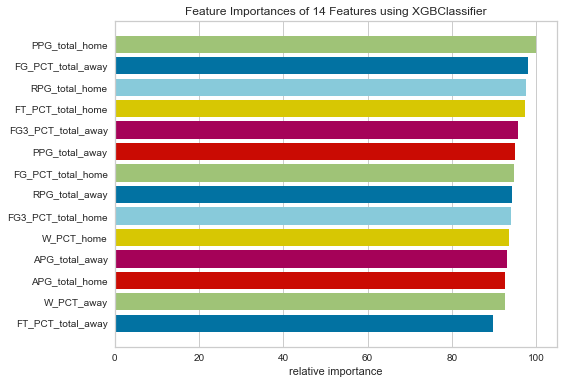

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'max_depth': 9}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2343
           1       0.51      0.52      0.51      2339

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



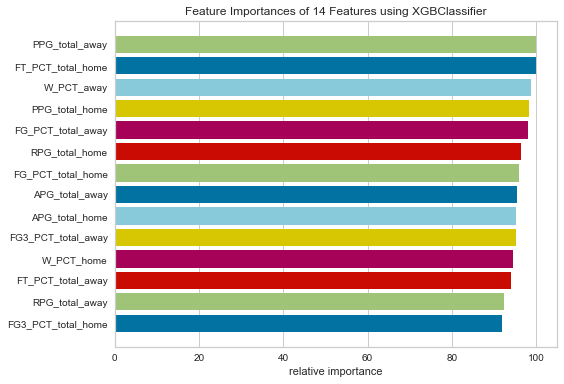

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'max_depth': 24}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2343
           1       0.51      0.51      0.51      2339

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



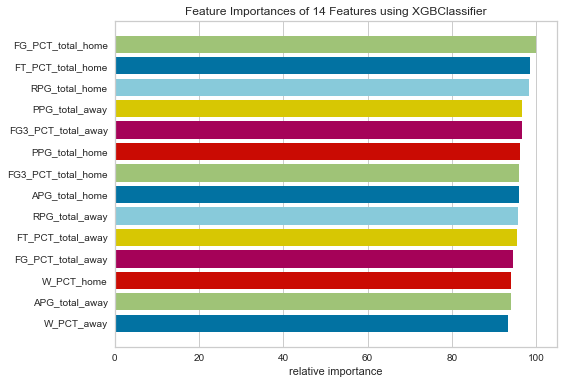

---------------------------------------------
Mean accuracy: 0.5138829560017086
Max accuracy: 0.5160187953865869
Min accuracy: 0.5121742844938061
i=20
AST:

Best XGBoost accuracy ({'max_depth': 9}): 0.59
              precision    recall  f1-score   support

           0       0.59      0.60      0.60      2556
           1       0.59      0.58      0.59      2540

    accuracy                           0.59      5096
   macro avg       0.59      0.59      0.59      5096
weighted avg       0.59      0.59      0.59      5096



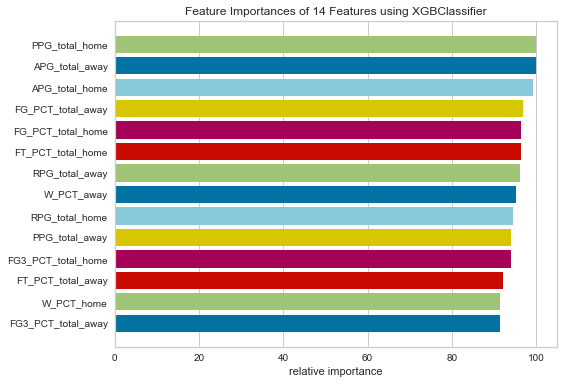

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'max_depth': 11}): 0.58
              precision    recall  f1-score   support

           0       0.59      0.58      0.58      2578
           1       0.58      0.59      0.58      2517

    accuracy                           0.58      5095
   macro avg       0.58      0.58      0.58      5095
weighted avg       0.58      0.58      0.58      5095



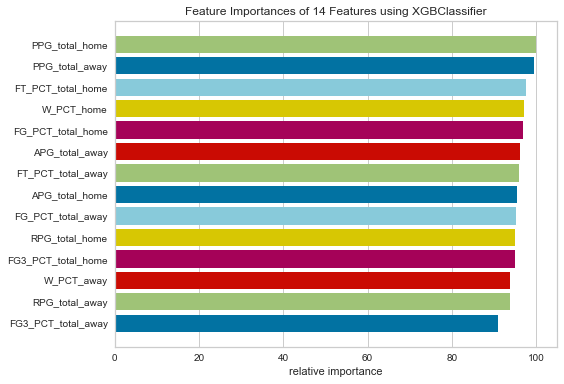

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'max_depth': 10}): 0.58
              precision    recall  f1-score   support

           0       0.57      0.59      0.58      2522
           1       0.59      0.57      0.58      2573

    accuracy                           0.58      5095
   macro avg       0.58      0.58      0.58      5095
weighted avg       0.58      0.58      0.58      5095



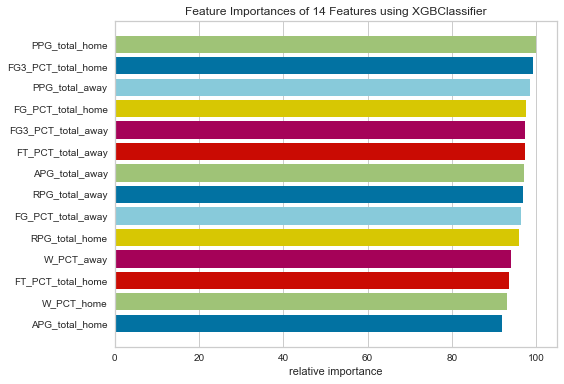

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'max_depth': 12}): 0.58
              precision    recall  f1-score   support

           0       0.57      0.58      0.58      2531
           1       0.58      0.57      0.58      2564

    accuracy                           0.58      5095
   macro avg       0.58      0.58      0.58      5095
weighted avg       0.58      0.58      0.58      5095



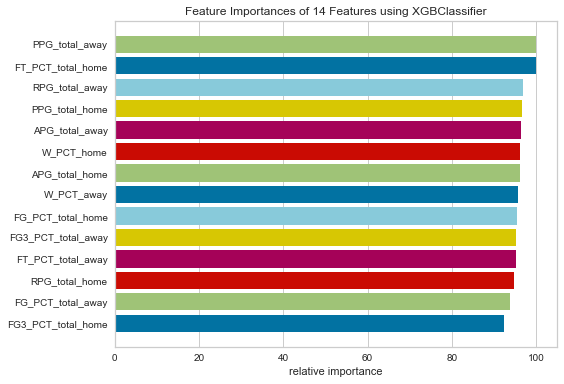

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'max_depth': 8}): 0.58
              precision    recall  f1-score   support

           0       0.58      0.59      0.58      2551
           1       0.58      0.57      0.57      2544

    accuracy                           0.58      5095
   macro avg       0.58      0.58      0.58      5095
weighted avg       0.58      0.58      0.58      5095



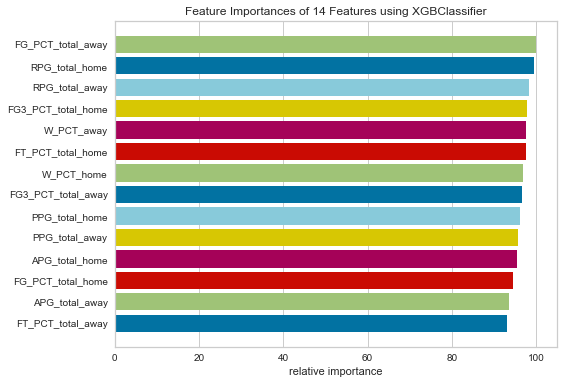

---------------------------------------------
Mean accuracy: 0.5823556989414622
Max accuracy: 0.5908555729984302
Min accuracy: 0.5762512266928361
i=25
REB:

Best XGBoost accuracy ({'max_depth': 12}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      2470
           1       0.55      0.53      0.54      2475

    accuracy                           0.55      4945
   macro avg       0.55      0.55      0.55      4945
weighted avg       0.55      0.55      0.55      4945



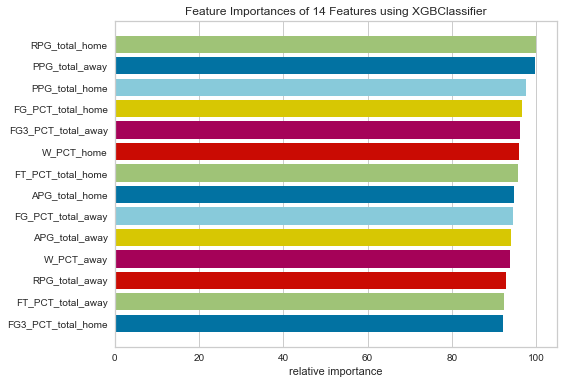

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'max_depth': 9}): 0.56
              precision    recall  f1-score   support

           0       0.54      0.59      0.56      2413
           1       0.57      0.53      0.55      2532

    accuracy                           0.56      4945
   macro avg       0.56      0.56      0.56      4945
weighted avg       0.56      0.56      0.56      4945



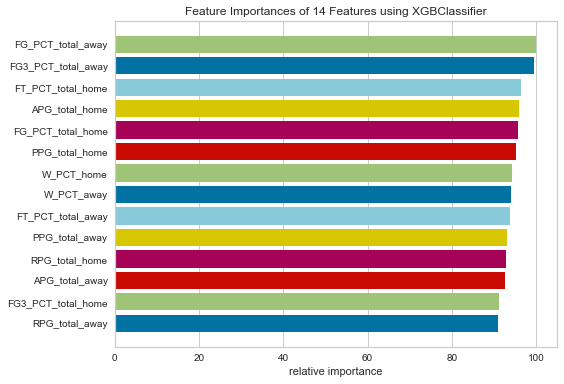

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'max_depth': 10}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.56      0.56      2479
           1       0.55      0.54      0.54      2465

    accuracy                           0.55      4944
   macro avg       0.55      0.55      0.55      4944
weighted avg       0.55      0.55      0.55      4944



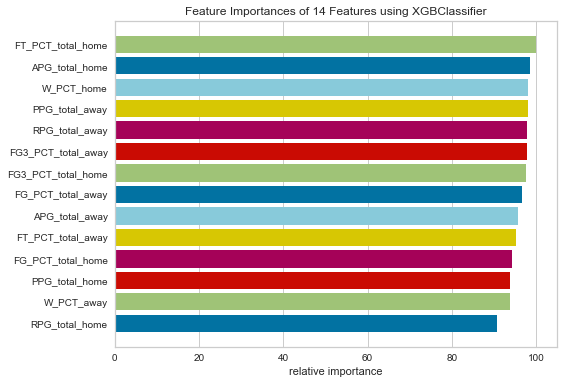

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'max_depth': 11}): 0.56
              precision    recall  f1-score   support

           0       0.56      0.56      0.56      2473
           1       0.56      0.55      0.56      2471

    accuracy                           0.56      4944
   macro avg       0.56      0.56      0.56      4944
weighted avg       0.56      0.56      0.56      4944



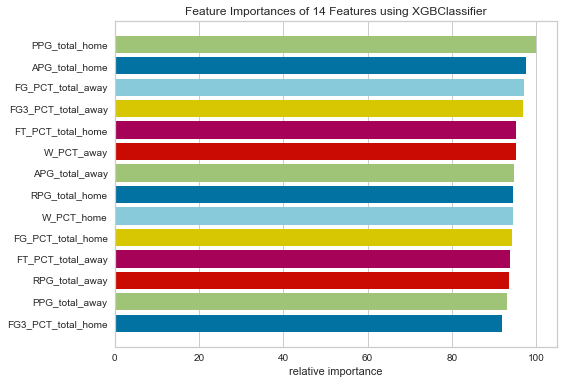

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'max_depth': 8}): 0.54
              precision    recall  f1-score   support

           0       0.55      0.53      0.54      2526
           1       0.53      0.55      0.54      2418

    accuracy                           0.54      4944
   macro avg       0.54      0.54      0.54      4944
weighted avg       0.54      0.54      0.54      4944



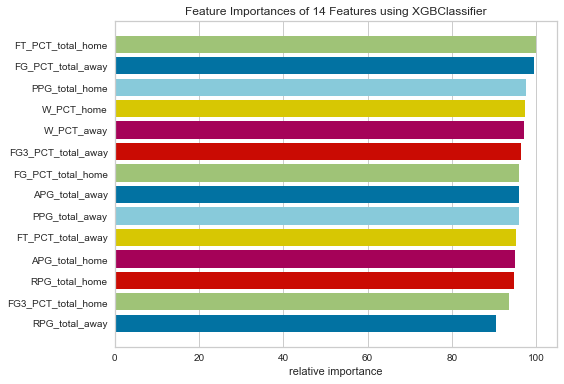

---------------------------------------------
Mean accuracy: 0.5533926692811868
Max accuracy: 0.5587462082912033
Min accuracy: 0.5478260869565217


In [25]:
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'max_depth': [*range(3,30)],
})

## Try prune reg_lambda

i=0
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.05}): 0.59
              precision    recall  f1-score   support

           0       0.58      0.62      0.60      2695
           1       0.61      0.56      0.58      2789

    accuracy                           0.59      5484
   macro avg       0.59      0.59      0.59      5484
weighted avg       0.59      0.59      0.59      5484



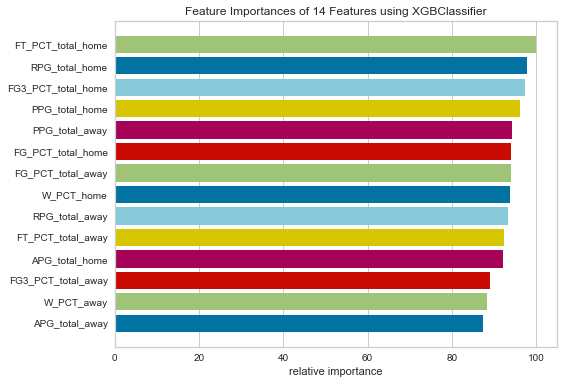

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.25}): 0.60
              precision    recall  f1-score   support

           0       0.60      0.63      0.61      2780
           1       0.60      0.56      0.58      2704

    accuracy                           0.60      5484
   macro avg       0.60      0.60      0.60      5484
weighted avg       0.60      0.60      0.60      5484



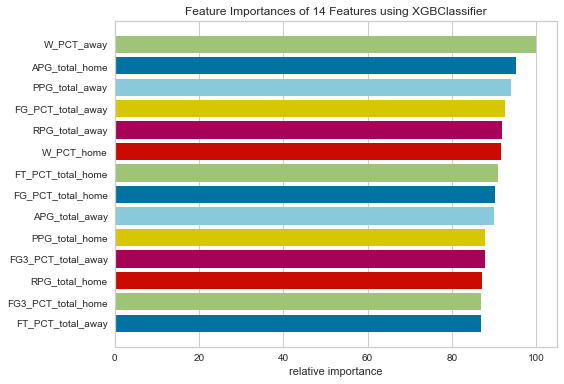

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.1}): 0.60
              precision    recall  f1-score   support

           0       0.60      0.63      0.61      2727
           1       0.61      0.58      0.59      2757

    accuracy                           0.60      5484
   macro avg       0.60      0.60      0.60      5484
weighted avg       0.60      0.60      0.60      5484



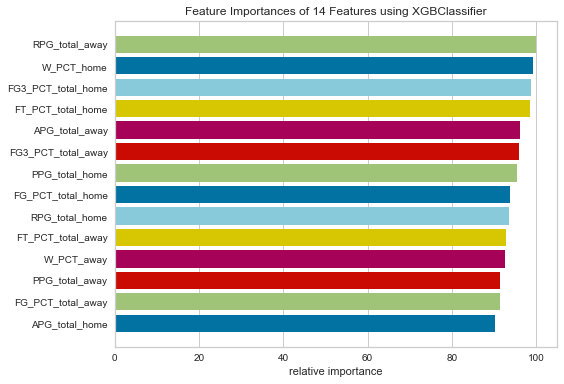

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.0}): 0.60
              precision    recall  f1-score   support

           0       0.59      0.63      0.61      2715
           1       0.61      0.57      0.59      2768

    accuracy                           0.60      5483
   macro avg       0.60      0.60      0.60      5483
weighted avg       0.60      0.60      0.60      5483



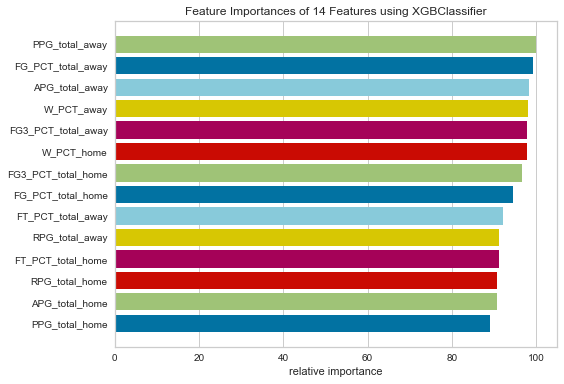

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'reg_lambda': 0.05}): 0.61
              precision    recall  f1-score   support

           0       0.61      0.62      0.62      2792
           1       0.60      0.60      0.60      2691

    accuracy                           0.61      5483
   macro avg       0.61      0.61      0.61      5483
weighted avg       0.61      0.61      0.61      5483



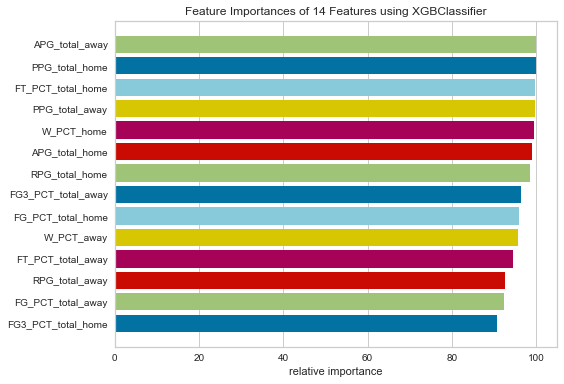

---------------------------------------------
Mean accuracy: 0.5972190932838893
Max accuracy: 0.6028446389496718
Min accuracy: 0.5919037199124726
i=5
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.7}): 0.56
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      2614
           1       0.55      0.55      0.55      2495

    accuracy                           0.56      5109
   macro avg       0.56      0.56      0.56      5109
weighted avg       0.56      0.56      0.56      5109



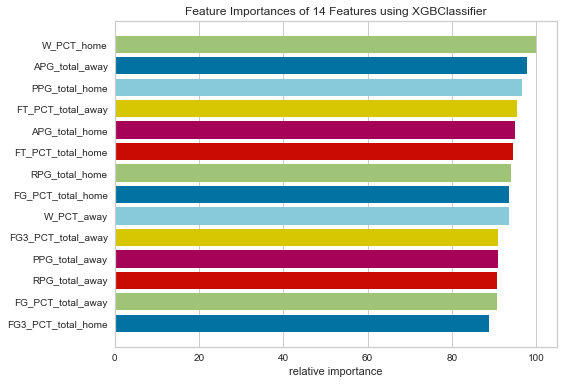

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.25}): 0.55
              precision    recall  f1-score   support

           0       0.56      0.57      0.56      2571
           1       0.55      0.54      0.55      2538

    accuracy                           0.55      5109
   macro avg       0.55      0.55      0.55      5109
weighted avg       0.55      0.55      0.55      5109



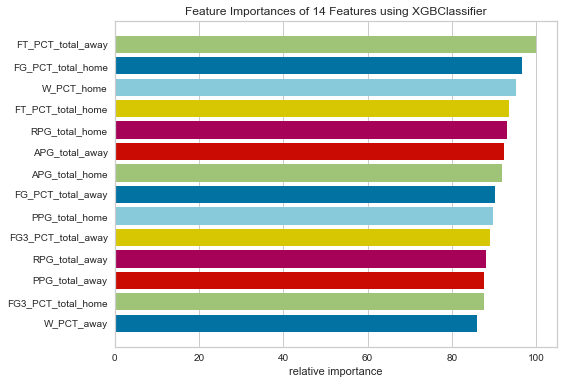

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.25}): 0.56
              precision    recall  f1-score   support

           0       0.56      0.57      0.56      2559
           1       0.56      0.54      0.55      2549

    accuracy                           0.56      5108
   macro avg       0.56      0.56      0.56      5108
weighted avg       0.56      0.56      0.56      5108



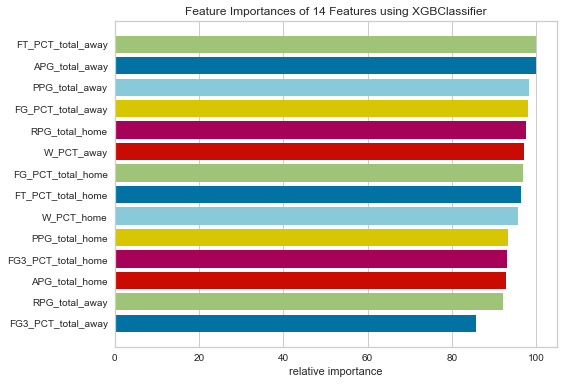

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.0}): 0.57
              precision    recall  f1-score   support

           0       0.55      0.61      0.58      2470
           1       0.59      0.53      0.56      2638

    accuracy                           0.57      5108
   macro avg       0.57      0.57      0.57      5108
weighted avg       0.57      0.57      0.57      5108



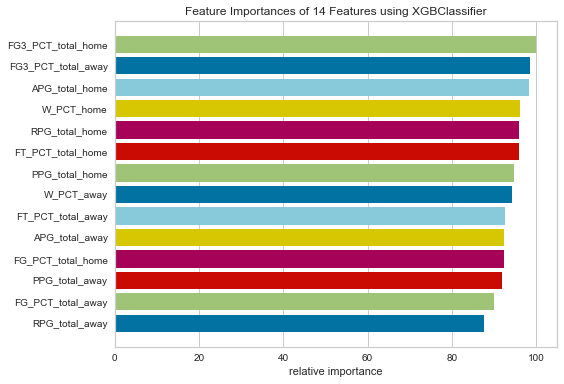

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'reg_lambda': 0.55}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      2557
           1       0.55      0.53      0.54      2551

    accuracy                           0.55      5108
   macro avg       0.55      0.55      0.55      5108
weighted avg       0.55      0.55      0.55      5108



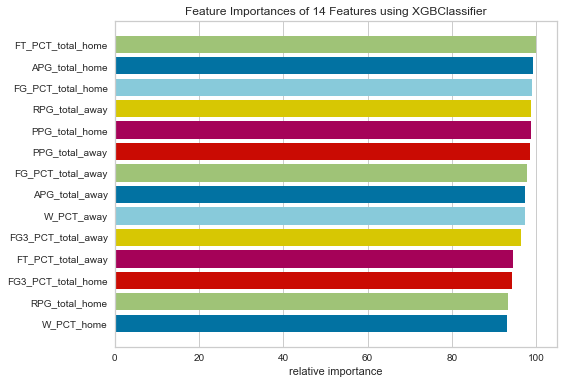

---------------------------------------------
Mean accuracy: 0.5604875959371527
Max accuracy: 0.566953797963978
Min accuracy: 0.5539244470542181
i=10
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.4}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2365
           1       0.51      0.52      0.51      2346

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



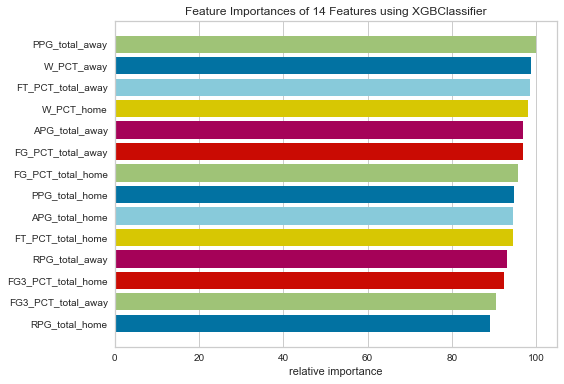

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.3}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      2402
           1       0.50      0.51      0.51      2309

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



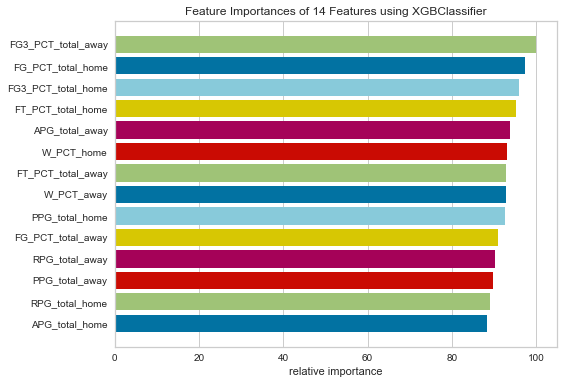

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'reg_lambda': 1}): 0.51
              precision    recall  f1-score   support

           0       0.49      0.53      0.51      2284
           1       0.52      0.49      0.50      2427

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



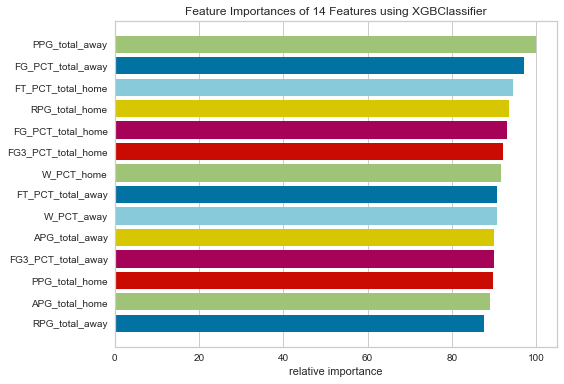

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.65}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      2307
           1       0.51      0.49      0.50      2404

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.50      0.50      0.50      4711



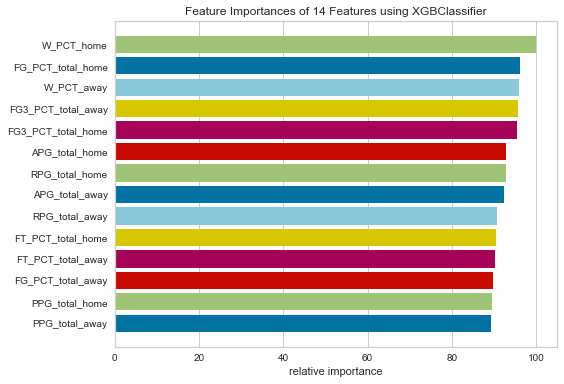

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'reg_lambda': 0.15}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      2419
           1       0.50      0.52      0.51      2291

    accuracy                           0.52      4710
   macro avg       0.52      0.52      0.52      4710
weighted avg       0.52      0.52      0.52      4710



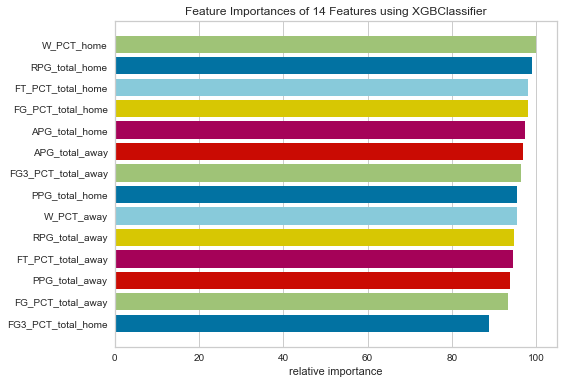

---------------------------------------------
Mean accuracy: 0.5070579494799405
Max accuracy: 0.5130545531734239
Min accuracy: 0.501167480365103
i=15
FT:

Best XGBoost accuracy ({'reg_lambda': 0.65}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      2337
           1       0.51      0.52      0.51      2345

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



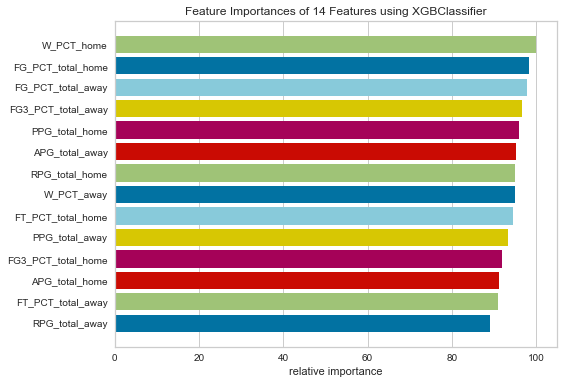

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'reg_lambda': 0.2}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      2322
           1       0.51      0.49      0.50      2360

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



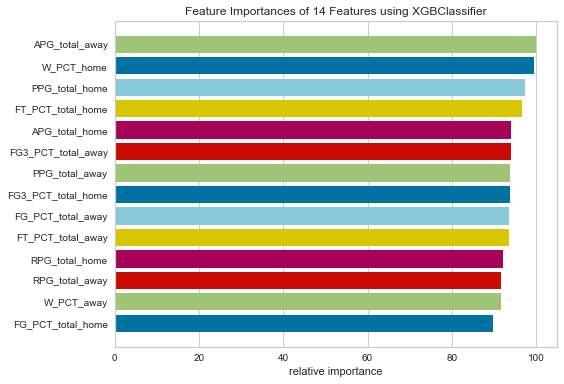

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'reg_lambda': 0.05}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      2360
           1       0.51      0.53      0.52      2322

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



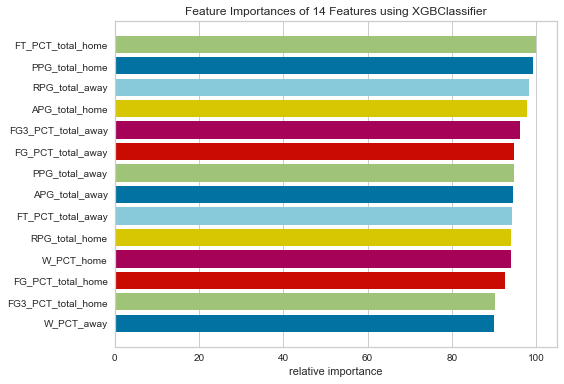

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'reg_lambda': 0.25}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2343
           1       0.51      0.52      0.51      2339

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



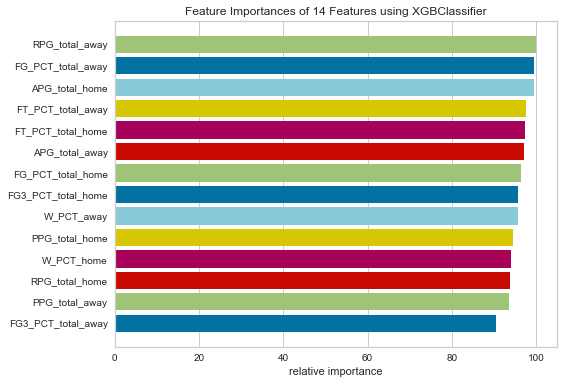

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'reg_lambda': 0.55}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2343
           1       0.51      0.52      0.52      2339

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



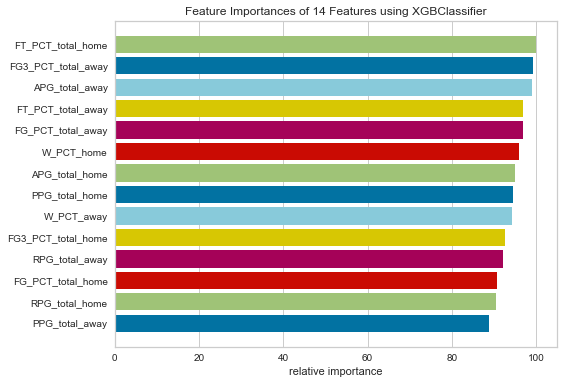

---------------------------------------------
Mean accuracy: 0.5101986330627937
Max accuracy: 0.5128150363092695
Min accuracy: 0.5076890217855617
i=20
AST:

Best XGBoost accuracy ({'reg_lambda': 0.15}): 0.56
              precision    recall  f1-score   support

           0       0.56      0.59      0.57      2556
           1       0.56      0.54      0.55      2540

    accuracy                           0.56      5096
   macro avg       0.56      0.56      0.56      5096
weighted avg       0.56      0.56      0.56      5096



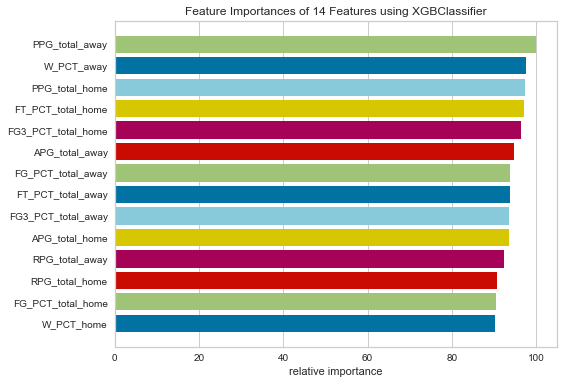

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'reg_lambda': 0.2}): 0.56
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      2578
           1       0.56      0.55      0.56      2517

    accuracy                           0.56      5095
   macro avg       0.56      0.56      0.56      5095
weighted avg       0.56      0.56      0.56      5095



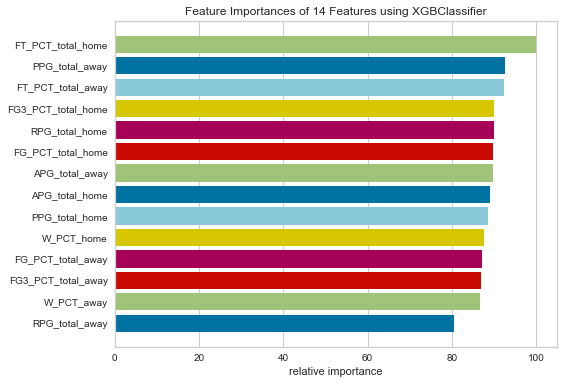

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'reg_lambda': 0.2}): 0.56
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      2522
           1       0.56      0.54      0.55      2573

    accuracy                           0.56      5095
   macro avg       0.56      0.56      0.56      5095
weighted avg       0.56      0.56      0.56      5095



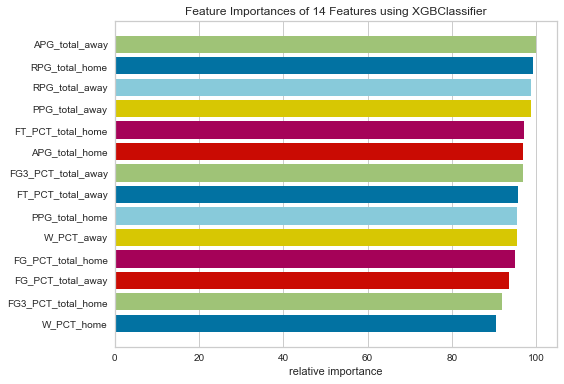

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'reg_lambda': 0.05}): 0.56
              precision    recall  f1-score   support

           0       0.55      0.58      0.56      2531
           1       0.56      0.54      0.55      2564

    accuracy                           0.56      5095
   macro avg       0.56      0.56      0.56      5095
weighted avg       0.56      0.56      0.56      5095



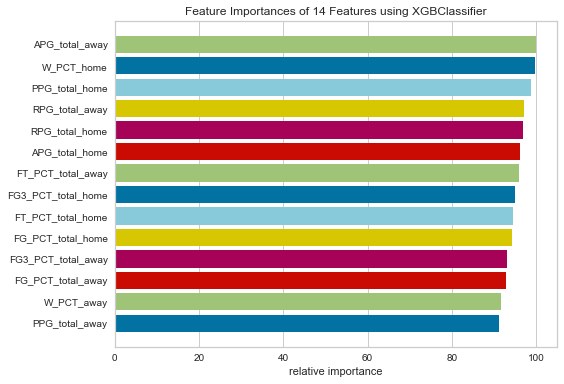

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'reg_lambda': 0.5}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.56      0.56      2551
           1       0.55      0.54      0.54      2544

    accuracy                           0.55      5095
   macro avg       0.55      0.55      0.55      5095
weighted avg       0.55      0.55      0.55      5095



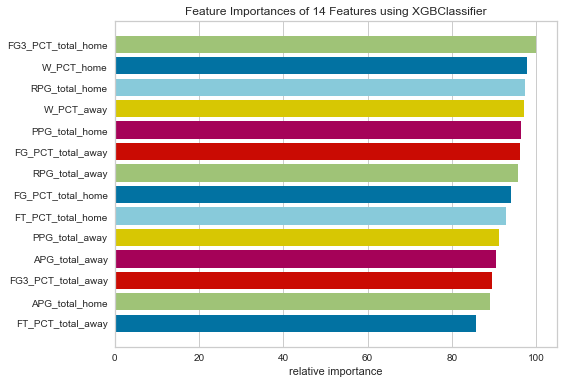

---------------------------------------------
Mean accuracy: 0.5590499697274547
Max accuracy: 0.5631010794896958
Min accuracy: 0.5556427870461237
i=25
REB:

Best XGBoost accuracy ({'reg_lambda': 0.1}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.55      0.54      2470
           1       0.54      0.53      0.53      2475

    accuracy                           0.54      4945
   macro avg       0.54      0.54      0.54      4945
weighted avg       0.54      0.54      0.54      4945



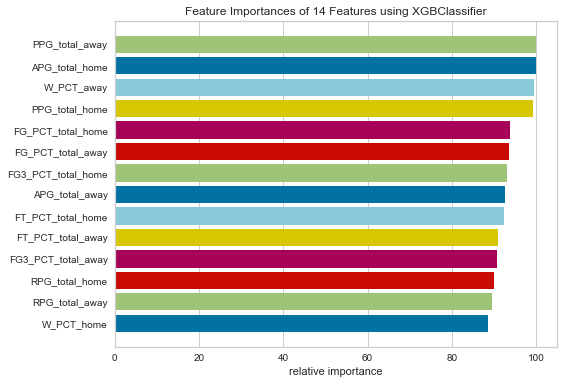

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'reg_lambda': 0.3}): 0.54
              precision    recall  f1-score   support

           0       0.52      0.56      0.54      2413
           1       0.55      0.52      0.53      2532

    accuracy                           0.54      4945
   macro avg       0.54      0.54      0.54      4945
weighted avg       0.54      0.54      0.54      4945



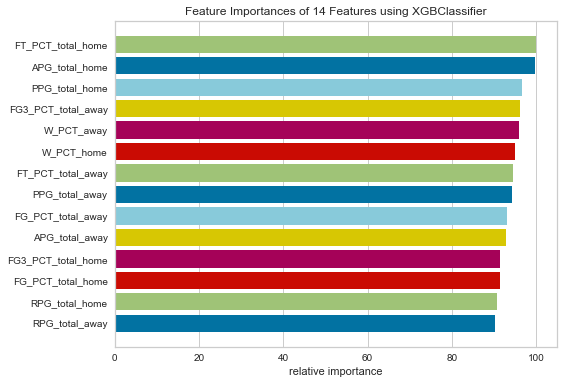

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'reg_lambda': 0.05}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2479
           1       0.53      0.53      0.53      2465

    accuracy                           0.53      4944
   macro avg       0.53      0.53      0.53      4944
weighted avg       0.53      0.53      0.53      4944



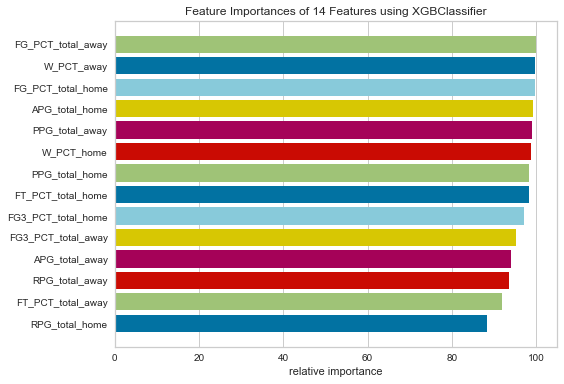

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'reg_lambda': 0.55}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2473
           1       0.54      0.52      0.53      2471

    accuracy                           0.53      4944
   macro avg       0.53      0.53      0.53      4944
weighted avg       0.53      0.53      0.53      4944



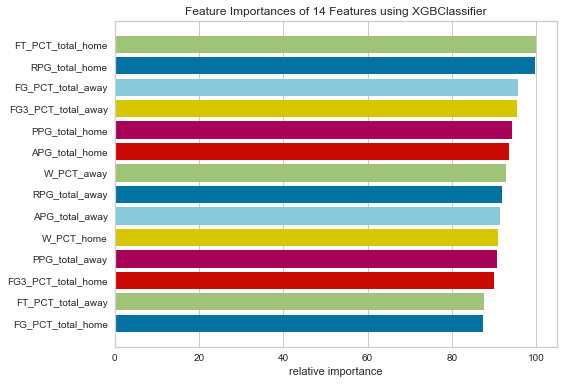

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'reg_lambda': 0.2}): 0.53
              precision    recall  f1-score   support

           0       0.54      0.53      0.54      2526
           1       0.52      0.53      0.53      2418

    accuracy                           0.53      4944
   macro avg       0.53      0.53      0.53      4944
weighted avg       0.53      0.53      0.53      4944



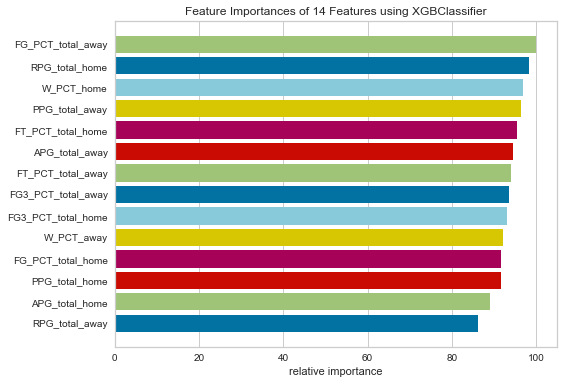

---------------------------------------------
Mean accuracy: 0.5340274062421262
Max accuracy: 0.5375126390293226
Min accuracy: 0.5281148867313916


In [26]:
# L2 regularization term on weights. Increasing this value will make model more conservative.

print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'reg_lambda': [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
})

## Try prune learning rate

i=0
WINNER:

Best XGBoost accuracy ({'learning_rate': 0.95}): 0.62
              precision    recall  f1-score   support

           0       0.60      0.68      0.63      2695
           1       0.64      0.56      0.60      2789

    accuracy                           0.62      5484
   macro avg       0.62      0.62      0.61      5484
weighted avg       0.62      0.62      0.61      5484



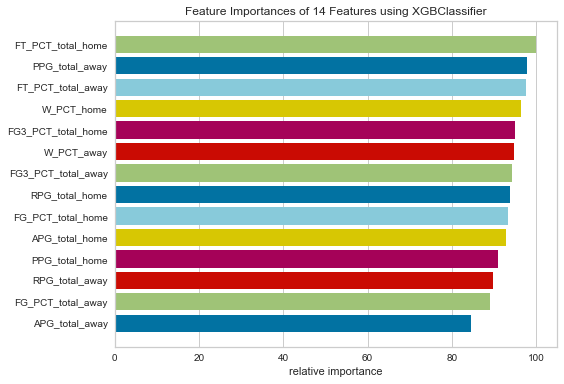

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.51
              precision    recall  f1-score   support

           0       0.51      1.00      0.67      2780
           1       0.00      0.00      0.00      2704

    accuracy                           0.51      5484
   macro avg       0.25      0.50      0.34      5484
weighted avg       0.26      0.51      0.34      5484



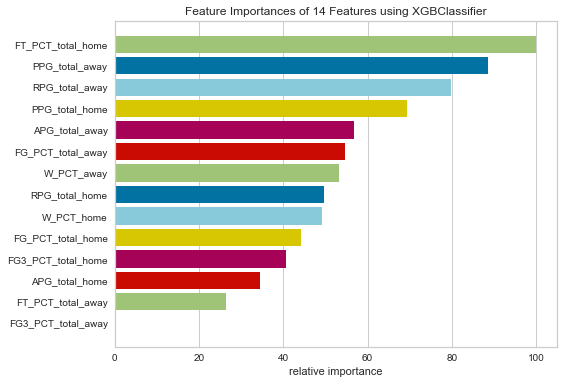

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2727
           1       0.00      0.00      0.00      2757

    accuracy                           0.50      5484
   macro avg       0.25      0.50      0.33      5484
weighted avg       0.25      0.50      0.33      5484



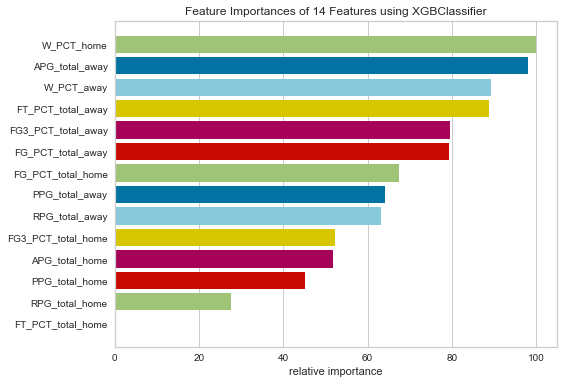

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2715
           1       0.00      0.00      0.00      2768

    accuracy                           0.50      5483
   macro avg       0.25      0.50      0.33      5483
weighted avg       0.25      0.50      0.33      5483



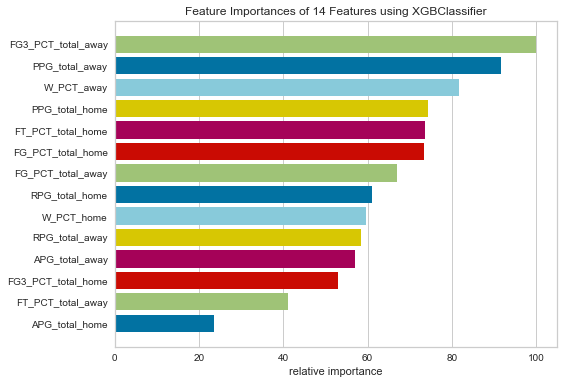

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'learning_rate': 0.9}): 0.62
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      2792
           1       0.62      0.58      0.60      2691

    accuracy                           0.62      5483
   macro avg       0.62      0.62      0.62      5483
weighted avg       0.62      0.62      0.62      5483



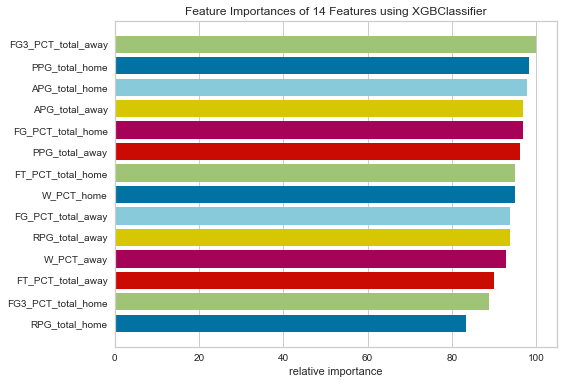

---------------------------------------------
Mean accuracy: 0.5287424857257224
Max accuracy: 0.6156090444930707
Min accuracy: 0.495166879445559
i=5
FGP:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.51
              precision    recall  f1-score   support

           0       0.51      1.00      0.68      2614
           1       0.00      0.00      0.00      2495

    accuracy                           0.51      5109
   macro avg       0.26      0.50      0.34      5109
weighted avg       0.26      0.51      0.35      5109



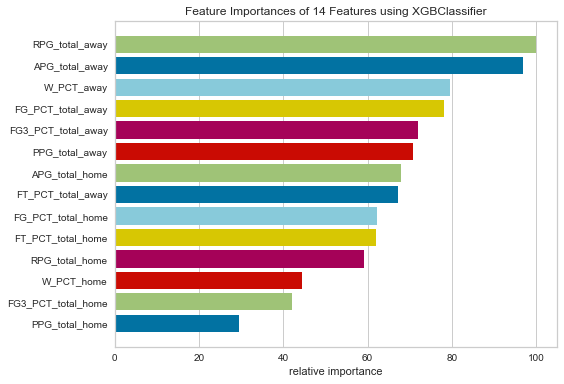

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2571
           1       0.00      0.00      0.00      2538

    accuracy                           0.50      5109
   macro avg       0.25      0.50      0.33      5109
weighted avg       0.25      0.50      0.34      5109



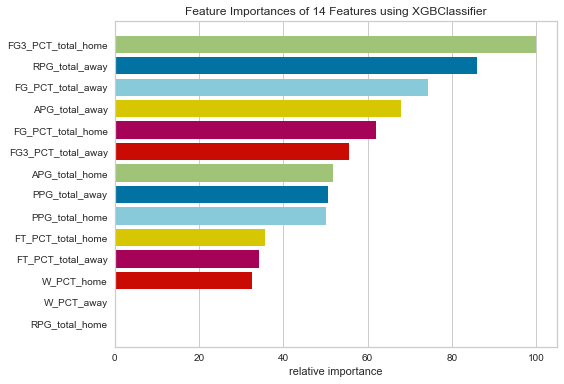

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'learning_rate': 0.8}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      2559
           1       0.55      0.52      0.54      2549

    accuracy                           0.55      5108
   macro avg       0.55      0.55      0.55      5108
weighted avg       0.55      0.55      0.55      5108



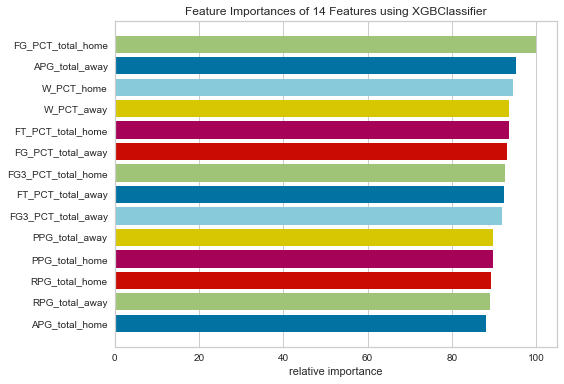

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'learning_rate': 0.85}): 0.55
              precision    recall  f1-score   support

           0       0.54      0.58      0.56      2470
           1       0.57      0.53      0.55      2638

    accuracy                           0.55      5108
   macro avg       0.55      0.55      0.55      5108
weighted avg       0.55      0.55      0.55      5108



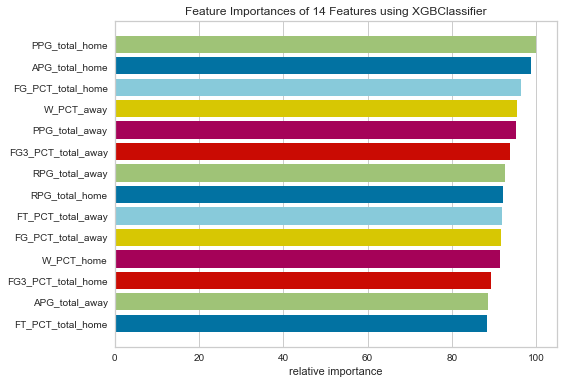

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'learning_rate': 0.95}): 0.57
              precision    recall  f1-score   support

           0       0.57      0.60      0.58      2557
           1       0.57      0.54      0.56      2551

    accuracy                           0.57      5108
   macro avg       0.57      0.57      0.57      5108
weighted avg       0.57      0.57      0.57      5108



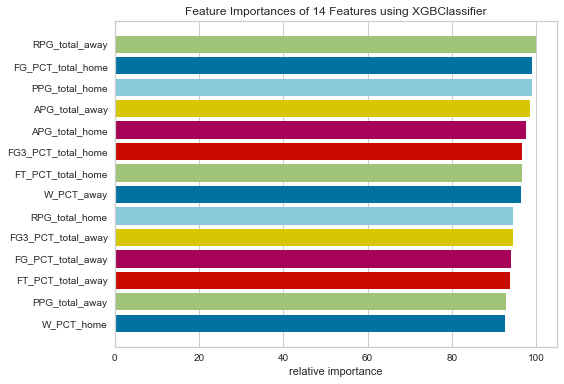

---------------------------------------------
Mean accuracy: 0.5291692014629242
Max accuracy: 0.553054032889585
Min accuracy: 0.5032295948326483
i=10
FG3:

Best XGBoost accuracy ({'learning_rate': 0.85}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      2365
           1       0.52      0.53      0.53      2346

    accuracy                           0.52      4711
   macro avg       0.52      0.52      0.52      4711
weighted avg       0.52      0.52      0.52      4711



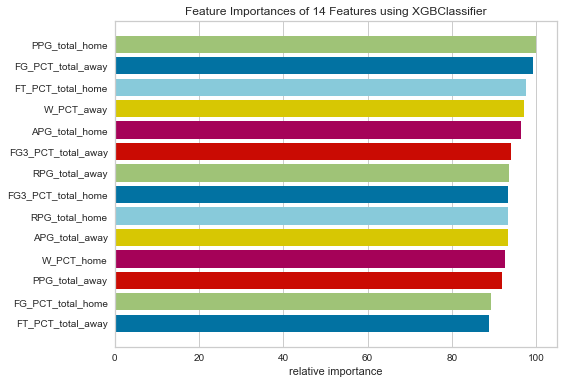

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'learning_rate': 0.7}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2402
           1       0.49      0.49      0.49      2309

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.50      0.50      0.50      4711



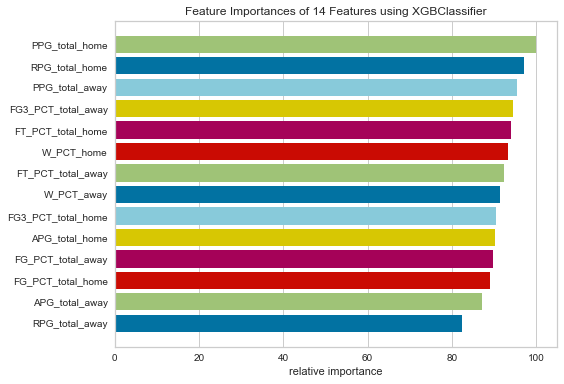

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.48
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      2284
           1       0.00      0.00      0.00      2427

    accuracy                           0.48      4711
   macro avg       0.24      0.50      0.33      4711
weighted avg       0.24      0.48      0.32      4711



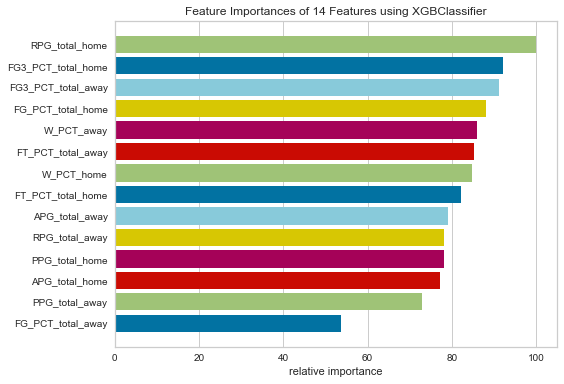

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'learning_rate': 0.75}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.52      0.50      2307
           1       0.51      0.49      0.50      2404

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.50      0.50      0.50      4711



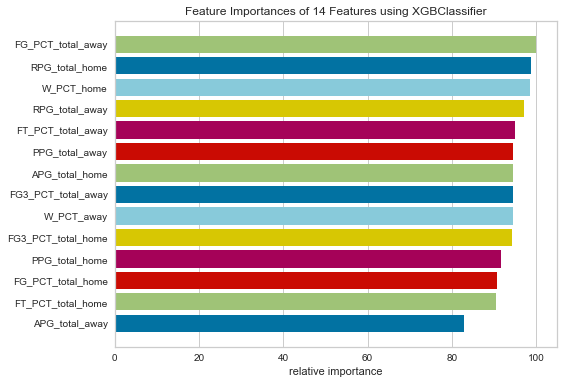

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.51
              precision    recall  f1-score   support

           0       0.51      1.00      0.68      2419
           1       0.00      0.00      0.00      2291

    accuracy                           0.51      4710
   macro avg       0.26      0.50      0.34      4710
weighted avg       0.26      0.51      0.35      4710



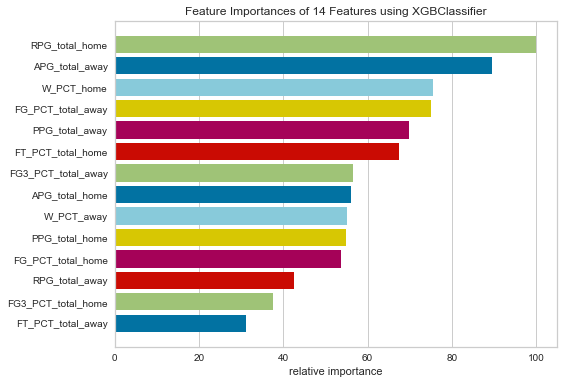

---------------------------------------------
Mean accuracy: 0.5023880280195288
Max accuracy: 0.5217575886223732
Min accuracy: 0.48482275525366164
i=15
FT:

Best XGBoost accuracy ({'learning_rate': 0.5}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2337
           1       0.52      0.53      0.52      2345

    accuracy                           0.52      4682
   macro avg       0.52      0.52      0.52      4682
weighted avg       0.52      0.52      0.52      4682



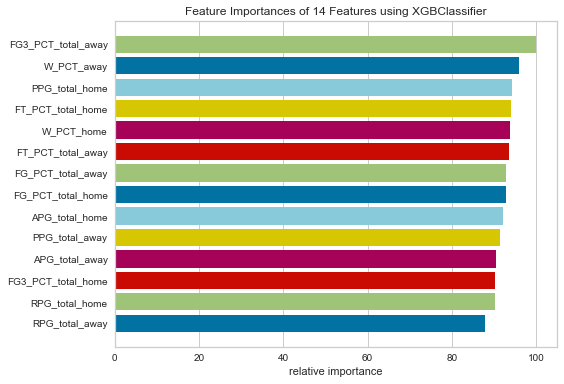

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'learning_rate': 0.75}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2322
           1       0.50      0.50      0.50      2360

    accuracy                           0.49      4682
   macro avg       0.49      0.49      0.49      4682
weighted avg       0.49      0.49      0.49      4682



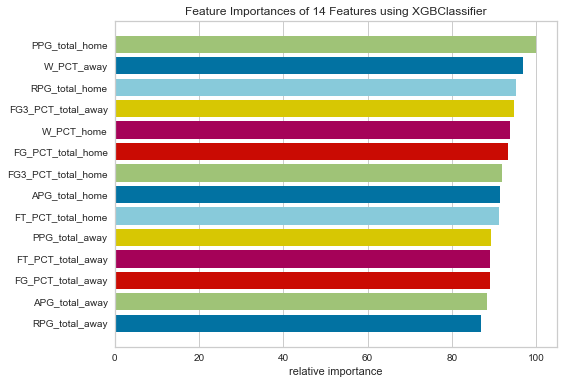

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'learning_rate': 0.95}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      2360
           1       0.52      0.53      0.52      2322

    accuracy                           0.52      4682
   macro avg       0.52      0.52      0.52      4682
weighted avg       0.52      0.52      0.52      4682



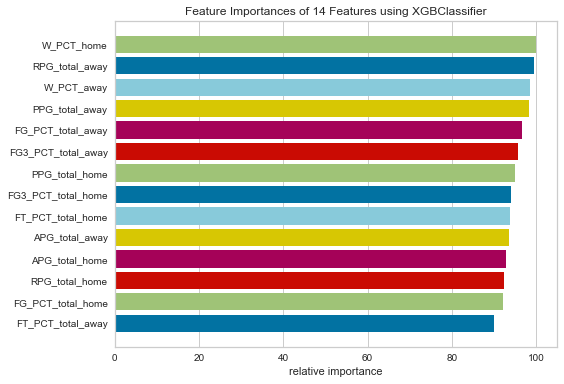

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'learning_rate': 0.55}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      2343
           1       0.50      0.51      0.51      2339

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



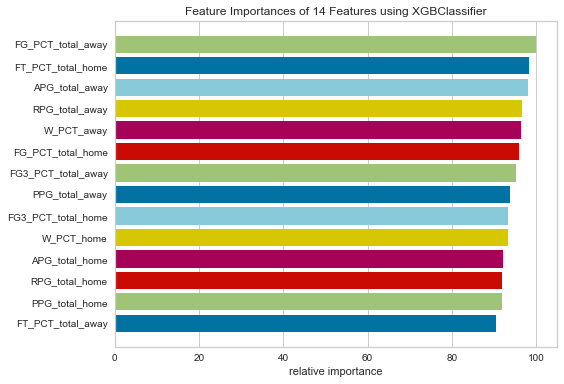

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'learning_rate': 0.45}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      2343
           1       0.52      0.53      0.52      2339

    accuracy                           0.52      4682
   macro avg       0.52      0.52      0.52      4682
weighted avg       0.52      0.52      0.52      4682



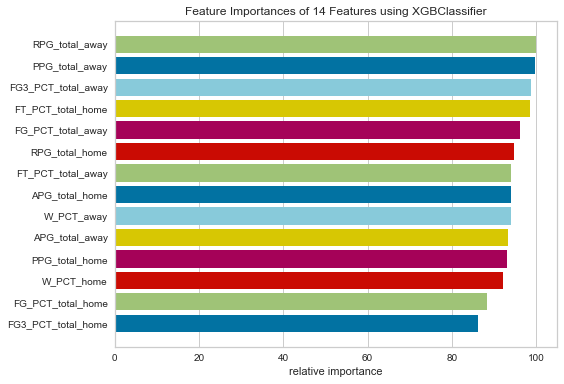

---------------------------------------------
Mean accuracy: 0.5092375053395986
Max accuracy: 0.5198633062793678
Min accuracy: 0.4942332336608287
i=20
AST:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2556
           1       0.00      0.00      0.00      2540

    accuracy                           0.50      5096
   macro avg       0.25      0.50      0.33      5096
weighted avg       0.25      0.50      0.34      5096



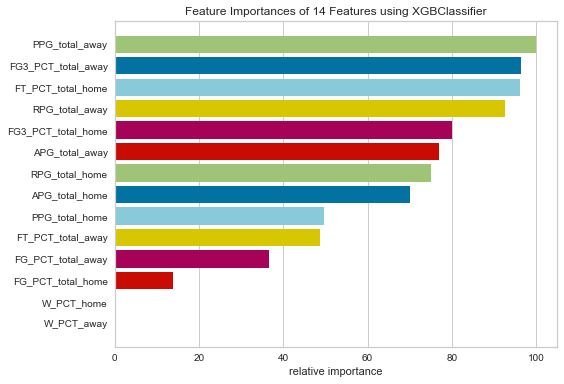

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.51
              precision    recall  f1-score   support

           0       0.51      1.00      0.67      2578
           1       0.00      0.00      0.00      2517

    accuracy                           0.51      5095
   macro avg       0.25      0.50      0.34      5095
weighted avg       0.26      0.51      0.34      5095



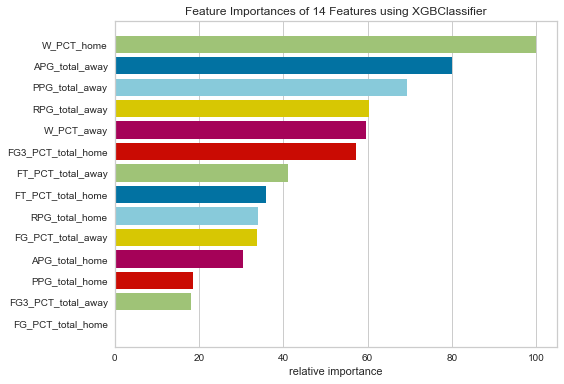

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'learning_rate': 0.95}): 0.58
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      2522
           1       0.59      0.55      0.57      2573

    accuracy                           0.58      5095
   macro avg       0.58      0.58      0.58      5095
weighted avg       0.58      0.58      0.58      5095



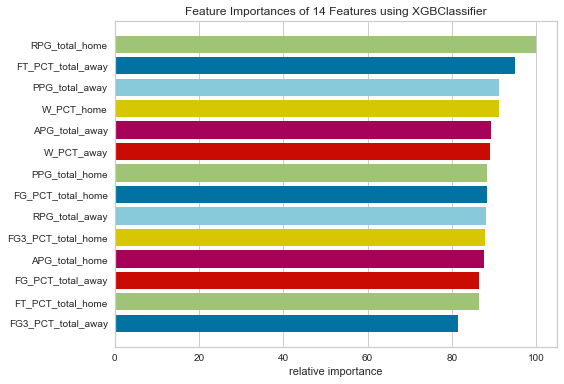

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2531
           1       0.00      0.00      0.00      2564

    accuracy                           0.50      5095
   macro avg       0.25      0.50      0.33      5095
weighted avg       0.25      0.50      0.33      5095



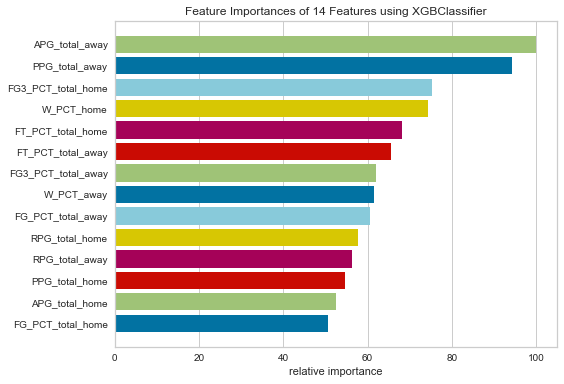

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'learning_rate': 0.75}): 0.57
              precision    recall  f1-score   support

           0       0.56      0.60      0.58      2551
           1       0.57      0.53      0.55      2544

    accuracy                           0.57      5095
   macro avg       0.57      0.57      0.57      5095
weighted avg       0.57      0.57      0.57      5095



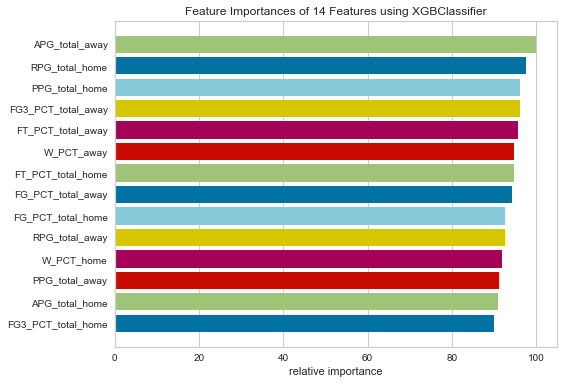

---------------------------------------------
Mean accuracy: 0.5202894224799454
Max accuracy: 0.5768400392541707
Min accuracy: 0.49676153091265945
i=25
REB:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2470
           1       0.00      0.00      0.00      2475

    accuracy                           0.50      4945
   macro avg       0.25      0.50      0.33      4945
weighted avg       0.25      0.50      0.33      4945



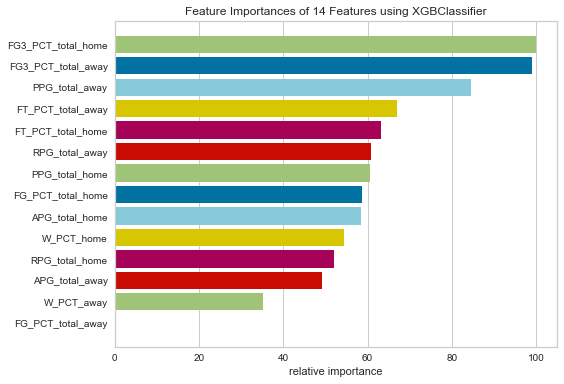

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2413
           1       0.00      0.00      0.00      2532

    accuracy                           0.49      4945
   macro avg       0.24      0.50      0.33      4945
weighted avg       0.24      0.49      0.32      4945



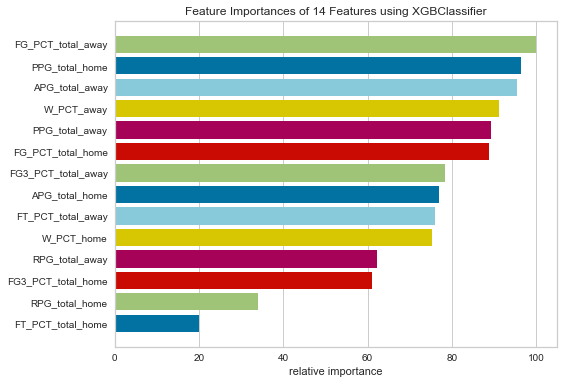

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'learning_rate': 0.0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2479
           1       0.00      0.00      0.00      2465

    accuracy                           0.50      4944
   macro avg       0.25      0.50      0.33      4944
weighted avg       0.25      0.50      0.33      4944



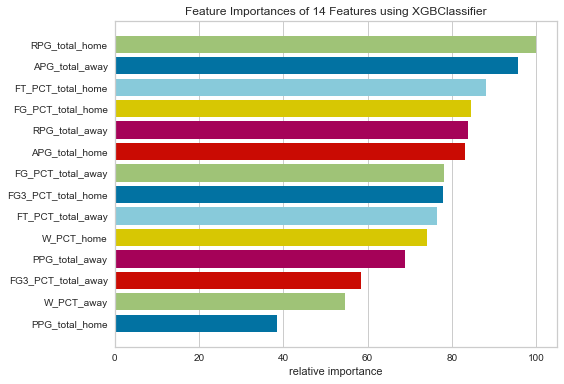

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'learning_rate': 0.95}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2473
           1       0.53      0.52      0.53      2471

    accuracy                           0.53      4944
   macro avg       0.53      0.53      0.53      4944
weighted avg       0.53      0.53      0.53      4944



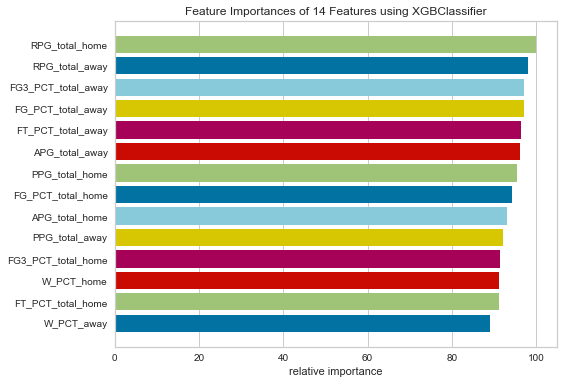

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'learning_rate': 0.85}): 0.54
              precision    recall  f1-score   support

           0       0.56      0.55      0.55      2526
           1       0.53      0.54      0.54      2418

    accuracy                           0.54      4944
   macro avg       0.54      0.54      0.54      4944
weighted avg       0.55      0.54      0.54      4944



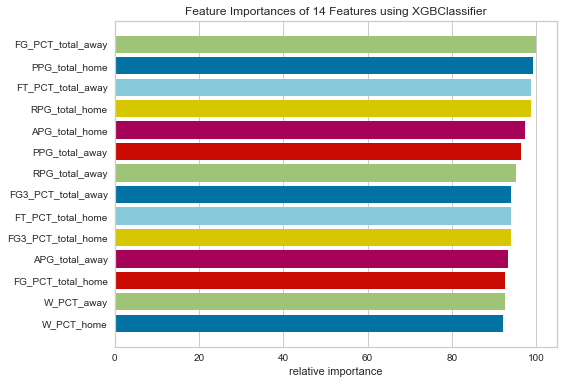

---------------------------------------------
Mean accuracy: 0.5057651971034126
Max accuracy: 0.5341828478964401
Min accuracy: 0.48796764408493426


In [27]:
# Step size shrinkage used in update to prevent overfitting.  
# After each boosting step, we can directly get the weights of new features. 
# learnig rate shrinks the feature weights to make the boosting process more conservative.

print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'learning_rate' : [0.0,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
})

## Try prune gamma

i=0
WINNER:

Best XGBoost accuracy ({'gamma': 1}): 0.60
              precision    recall  f1-score   support

           0       0.59      0.63      0.61      2695
           1       0.62      0.58      0.60      2789

    accuracy                           0.60      5484
   macro avg       0.60      0.60      0.60      5484
weighted avg       0.60      0.60      0.60      5484



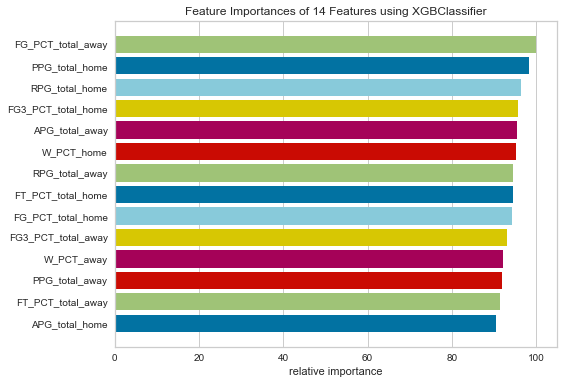

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'gamma': 5}): 0.55
              precision    recall  f1-score   support

           0       0.56      0.55      0.56      2780
           1       0.54      0.55      0.55      2704

    accuracy                           0.55      5484
   macro avg       0.55      0.55      0.55      5484
weighted avg       0.55      0.55      0.55      5484



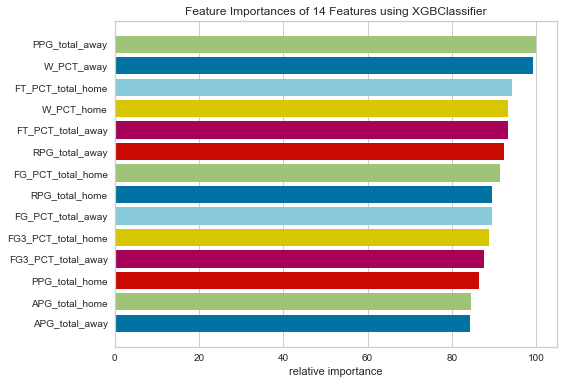

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'gamma': 3}): 0.59
              precision    recall  f1-score   support

           0       0.59      0.62      0.60      2727
           1       0.60      0.57      0.59      2757

    accuracy                           0.59      5484
   macro avg       0.59      0.59      0.59      5484
weighted avg       0.59      0.59      0.59      5484



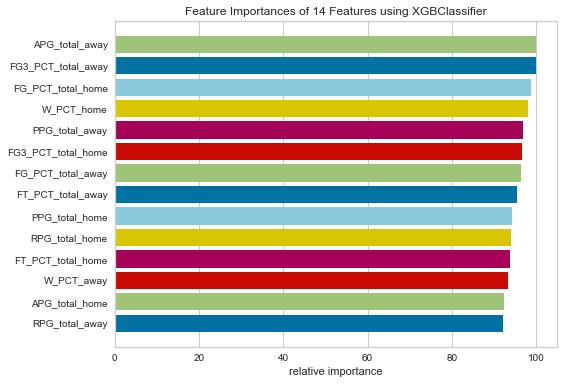

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'gamma': 0}): 0.60
              precision    recall  f1-score   support

           0       0.59      0.61      0.60      2715
           1       0.60      0.58      0.59      2768

    accuracy                           0.60      5483
   macro avg       0.60      0.60      0.60      5483
weighted avg       0.60      0.60      0.60      5483



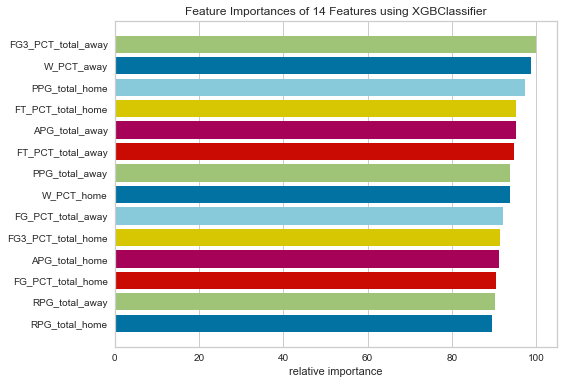

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'gamma': 5}): 0.58
              precision    recall  f1-score   support

           0       0.59      0.56      0.58      2792
           1       0.57      0.59      0.58      2691

    accuracy                           0.58      5483
   macro avg       0.58      0.58      0.58      5483
weighted avg       0.58      0.58      0.58      5483



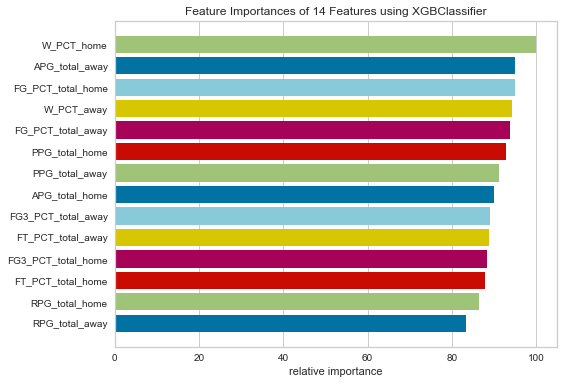

---------------------------------------------
Mean accuracy: 0.5856398209411412
Max accuracy: 0.6015681983953318
Min accuracy: 0.5514223194748359
i=5
FGP:

Best XGBoost accuracy ({'gamma': 29}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2614
           1       0.49      1.00      0.66      2495

    accuracy                           0.49      5109
   macro avg       0.24      0.50      0.33      5109
weighted avg       0.24      0.49      0.32      5109



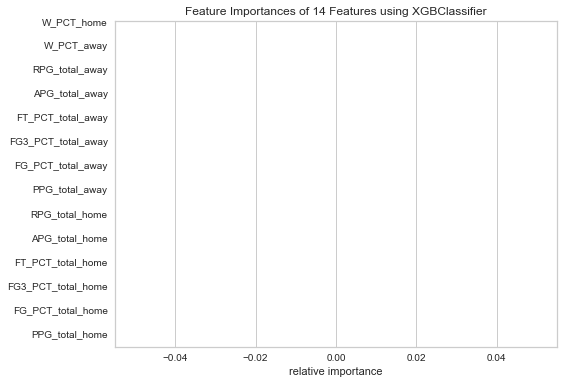

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'gamma': 1}): 0.56
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      2571
           1       0.56      0.56      0.56      2538

    accuracy                           0.56      5109
   macro avg       0.56      0.56      0.56      5109
weighted avg       0.56      0.56      0.56      5109



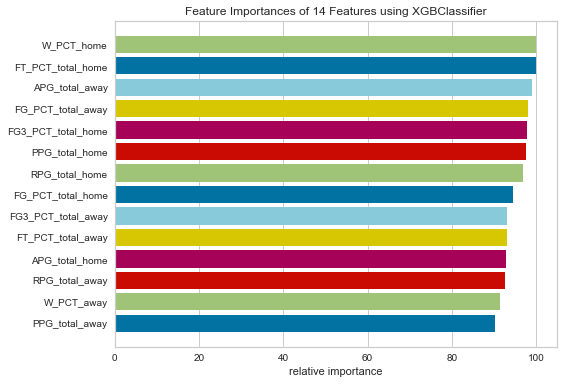

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'gamma': 1}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      2559
           1       0.55      0.52      0.54      2549

    accuracy                           0.55      5108
   macro avg       0.55      0.55      0.55      5108
weighted avg       0.55      0.55      0.55      5108



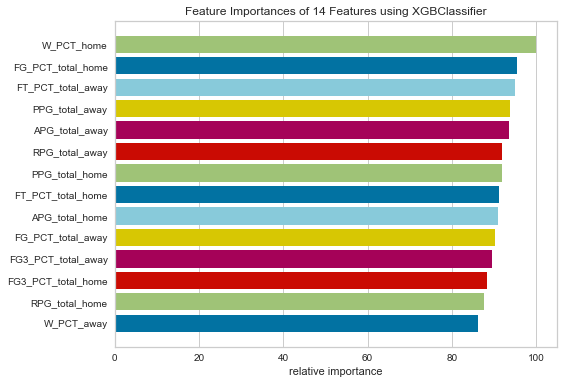

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'gamma': 3}): 0.55
              precision    recall  f1-score   support

           0       0.53      0.56      0.55      2470
           1       0.57      0.53      0.55      2638

    accuracy                           0.55      5108
   macro avg       0.55      0.55      0.55      5108
weighted avg       0.55      0.55      0.55      5108



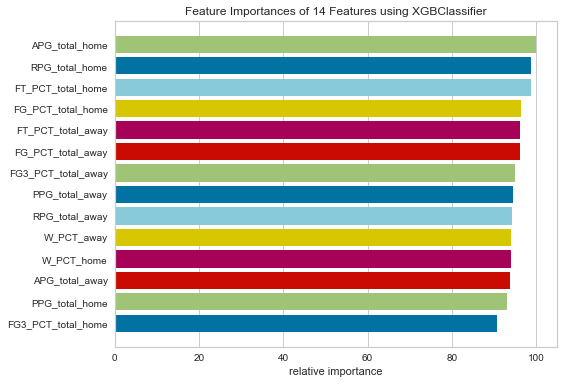

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'gamma': 3}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.55      0.55      2557
           1       0.54      0.53      0.54      2551

    accuracy                           0.54      5108
   macro avg       0.54      0.54      0.54      5108
weighted avg       0.54      0.54      0.54      5108



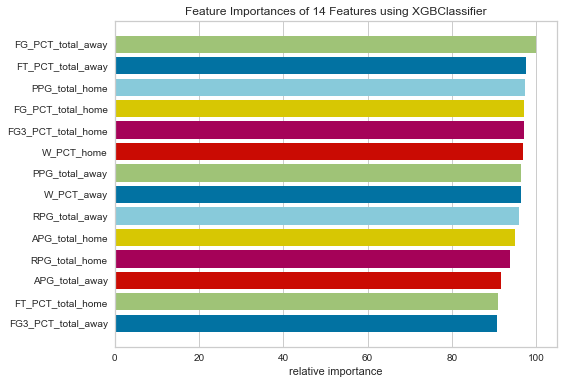

---------------------------------------------
Mean accuracy: 0.5370471777122473
Max accuracy: 0.5637110980622431
Min accuracy: 0.4883538853004502
i=10
FG3:

Best XGBoost accuracy ({'gamma': 23}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2365
           1       0.50      1.00      0.66      2346

    accuracy                           0.50      4711
   macro avg       0.25      0.50      0.33      4711
weighted avg       0.25      0.50      0.33      4711



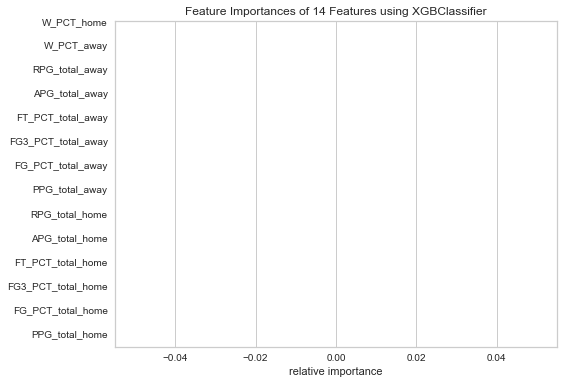

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'gamma': 21}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2402
           1       0.49      1.00      0.66      2309

    accuracy                           0.49      4711
   macro avg       0.25      0.50      0.33      4711
weighted avg       0.24      0.49      0.32      4711



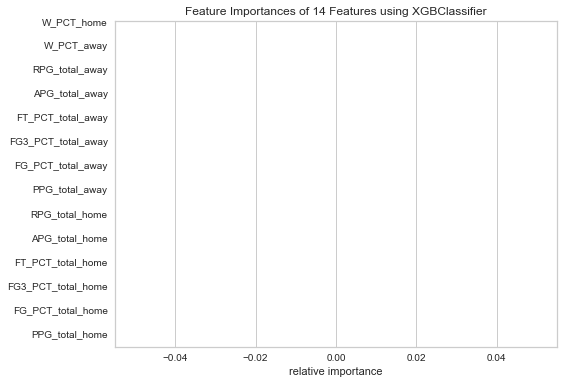

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'gamma': 21}): 0.48
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      2284
           1       0.00      0.00      0.00      2427

    accuracy                           0.48      4711
   macro avg       0.24      0.50      0.33      4711
weighted avg       0.24      0.48      0.32      4711



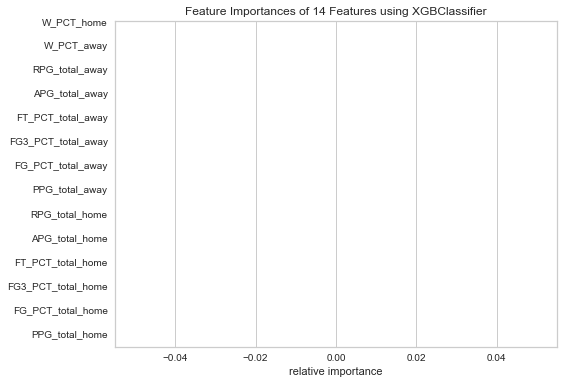

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'gamma': 21}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2307
           1       0.00      0.00      0.00      2404

    accuracy                           0.49      4711
   macro avg       0.24      0.50      0.33      4711
weighted avg       0.24      0.49      0.32      4711



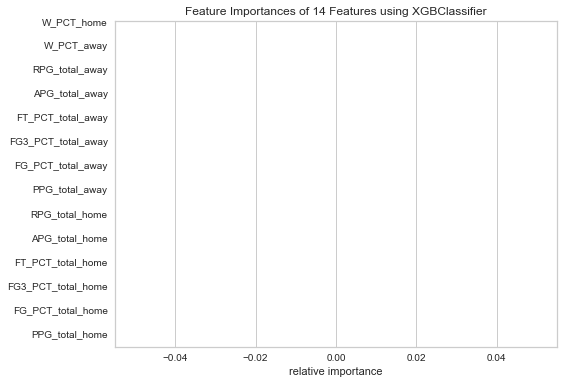

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'gamma': 21}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2419
           1       0.49      1.00      0.65      2291

    accuracy                           0.49      4710
   macro avg       0.24      0.50      0.33      4710
weighted avg       0.24      0.49      0.32      4710



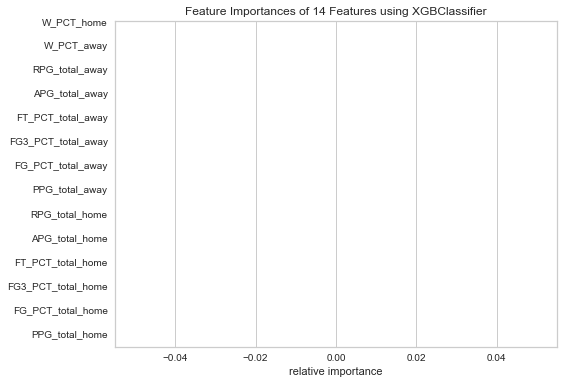

---------------------------------------------
Mean accuracy: 0.49066015707917643
Max accuracy: 0.4979834430057313
Min accuracy: 0.48482275525366164
i=15
FT:

Best XGBoost accuracy ({'gamma': 27}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2337
           1       0.00      0.00      0.00      2345

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



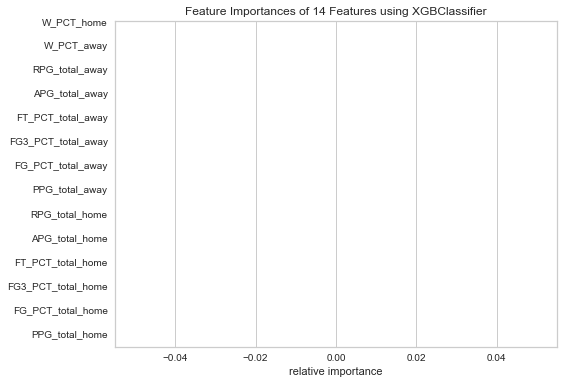

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'gamma': 25}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2322
           1       0.00      0.00      0.00      2360

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



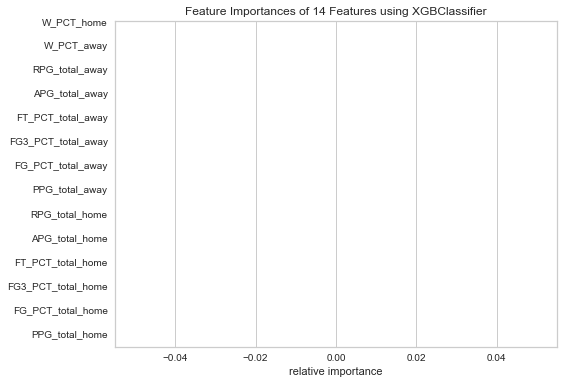

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'gamma': 8}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2360
           1       0.51      0.51      0.51      2322

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



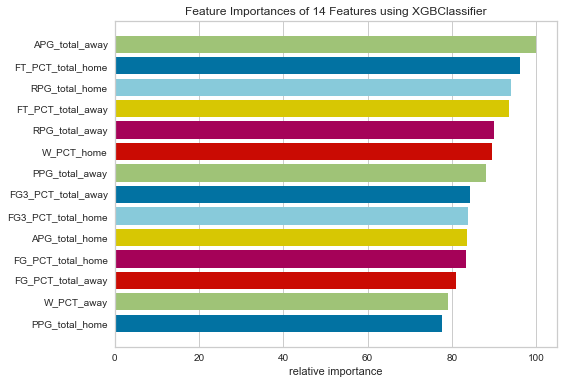

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'gamma': 21}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2343
           1       0.50      1.00      0.67      2339

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



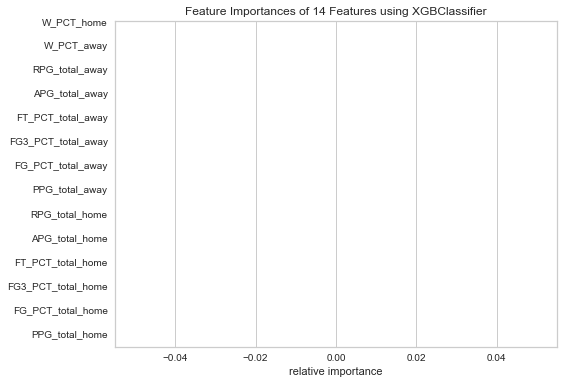

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'gamma': 8}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.54      0.52      2343
           1       0.50      0.45      0.47      2339

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



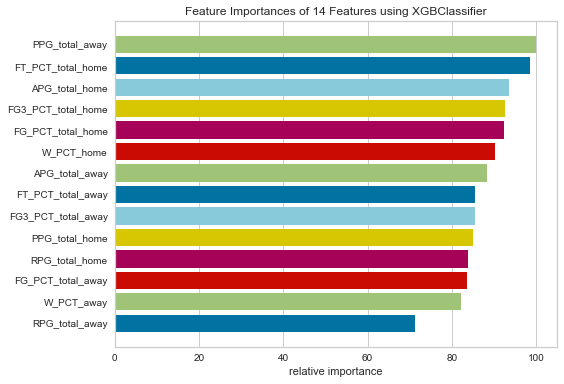

---------------------------------------------
Mean accuracy: 0.5009611277231952
Max accuracy: 0.5091841093549765
Min accuracy: 0.4959419051687313
i=20
AST:

Best XGBoost accuracy ({'gamma': 3}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.56      0.55      2556
           1       0.54      0.53      0.53      2540

    accuracy                           0.54      5096
   macro avg       0.54      0.54      0.54      5096
weighted avg       0.54      0.54      0.54      5096



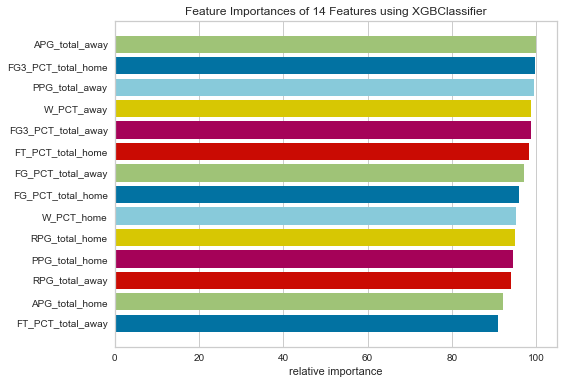

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'gamma': 0}): 0.56
              precision    recall  f1-score   support

           0       0.56      0.57      0.57      2578
           1       0.55      0.55      0.55      2517

    accuracy                           0.56      5095
   macro avg       0.56      0.56      0.56      5095
weighted avg       0.56      0.56      0.56      5095



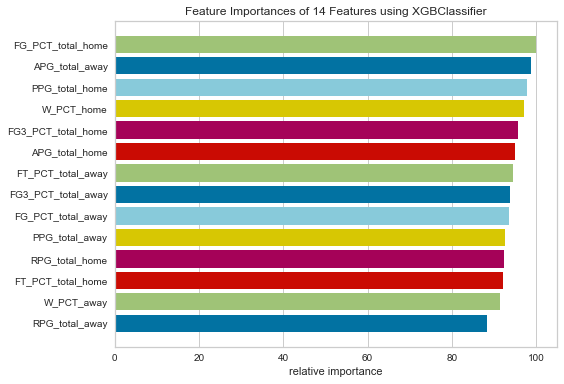

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'gamma': 1}): 0.55
              precision    recall  f1-score   support

           0       0.54      0.57      0.56      2522
           1       0.56      0.53      0.54      2573

    accuracy                           0.55      5095
   macro avg       0.55      0.55      0.55      5095
weighted avg       0.55      0.55      0.55      5095



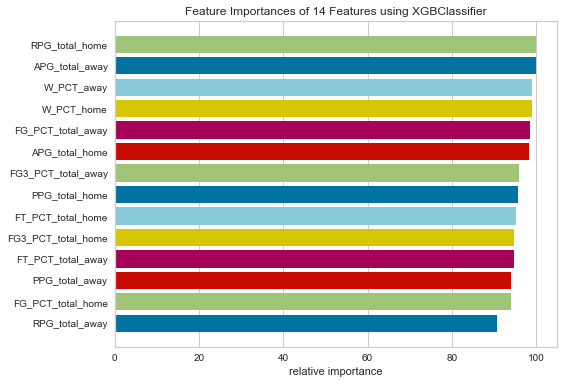

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'gamma': 1}): 0.56
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      2531
           1       0.56      0.54      0.55      2564

    accuracy                           0.56      5095
   macro avg       0.56      0.56      0.56      5095
weighted avg       0.56      0.56      0.56      5095



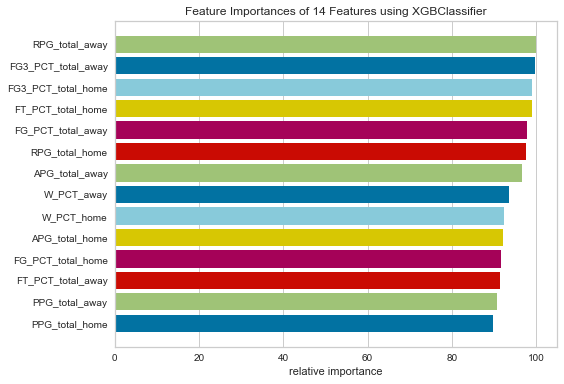

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'gamma': 2}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.56      0.56      2551
           1       0.55      0.54      0.55      2544

    accuracy                           0.55      5095
   macro avg       0.55      0.55      0.55      5095
weighted avg       0.55      0.55      0.55      5095



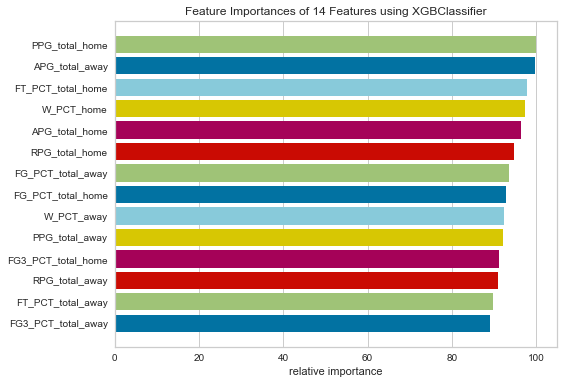

---------------------------------------------
Mean accuracy: 0.551788911004879
Max accuracy: 0.5589793915603533
Min accuracy: 0.5419937205651492
i=25
REB:

Best XGBoost accuracy ({'gamma': 1}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.54      0.53      2470
           1       0.53      0.53      0.53      2475

    accuracy                           0.53      4945
   macro avg       0.53      0.53      0.53      4945
weighted avg       0.53      0.53      0.53      4945



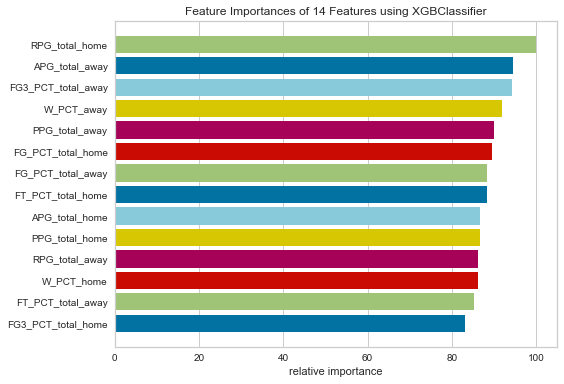

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'gamma': 2}): 0.54
              precision    recall  f1-score   support

           0       0.53      0.56      0.54      2413
           1       0.56      0.53      0.54      2532

    accuracy                           0.54      4945
   macro avg       0.54      0.54      0.54      4945
weighted avg       0.54      0.54      0.54      4945



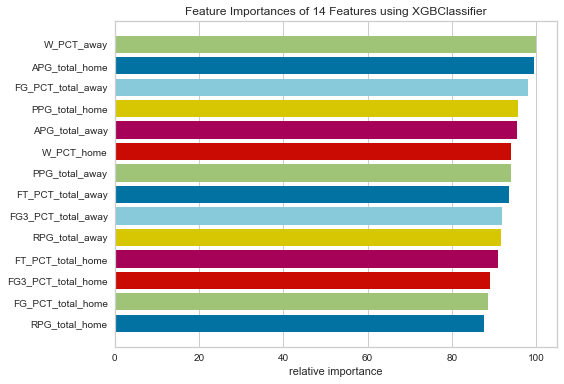

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'gamma': 0}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.54      0.53      2479
           1       0.53      0.53      0.53      2465

    accuracy                           0.53      4944
   macro avg       0.53      0.53      0.53      4944
weighted avg       0.53      0.53      0.53      4944



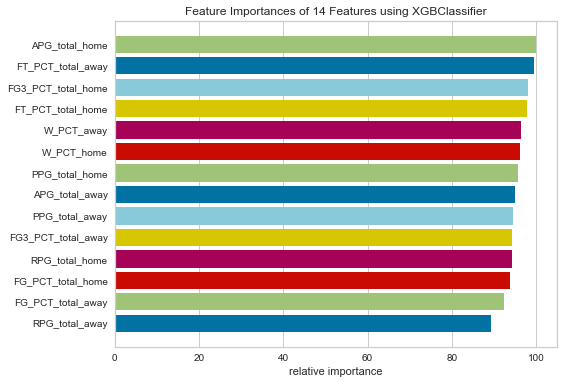

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'gamma': 2}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.53      0.53      2473
           1       0.53      0.54      0.54      2471

    accuracy                           0.54      4944
   macro avg       0.54      0.54      0.54      4944
weighted avg       0.54      0.54      0.54      4944



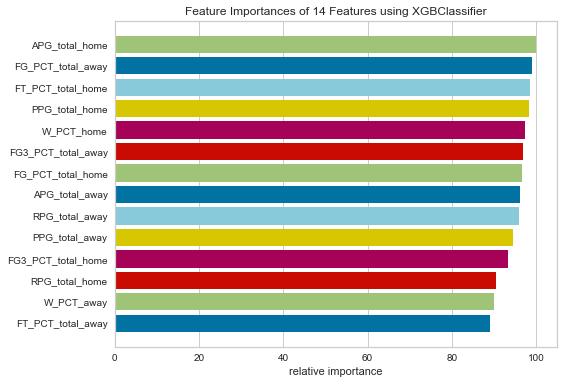

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'gamma': 1}): 0.53
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      2526
           1       0.52      0.53      0.53      2418

    accuracy                           0.53      4944
   macro avg       0.53      0.53      0.53      4944
weighted avg       0.53      0.53      0.53      4944



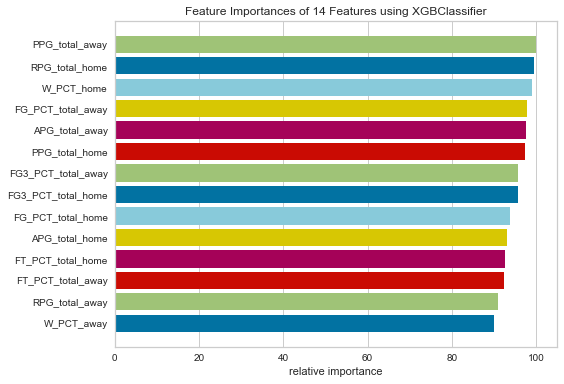

---------------------------------------------
Mean accuracy: 0.5354432127185448
Max accuracy: 0.5419615773508595
Min accuracy: 0.5313511326860841


In [28]:
# Minimum loss reduction required to make a further partition on a leaf node of the tree. 
# The larger gamma is, the more conservative the algorithm will be.

print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'gamma' : [*range(0,30)],
})

## Try prune scale_pos_weight

i=0
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 20}): 0.53
              precision    recall  f1-score   support

           0       0.72      0.07      0.13      2695
           1       0.52      0.97      0.68      2789

    accuracy                           0.53      5484
   macro avg       0.62      0.52      0.41      5484
weighted avg       0.62      0.53      0.41      5484



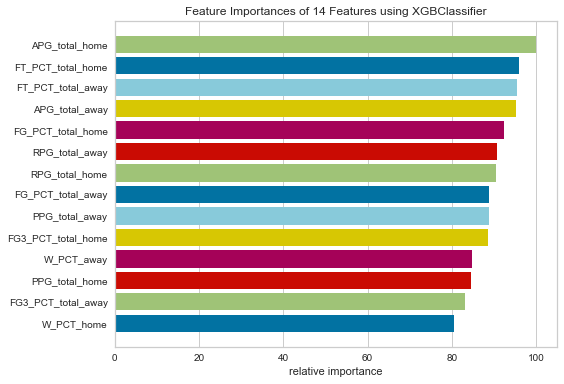

---------------------------------------------
i=1
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 19}): 0.52
              precision    recall  f1-score   support

           0       0.73      0.07      0.13      2780
           1       0.50      0.97      0.66      2704

    accuracy                           0.52      5484
   macro avg       0.62      0.52      0.40      5484
weighted avg       0.62      0.52      0.39      5484



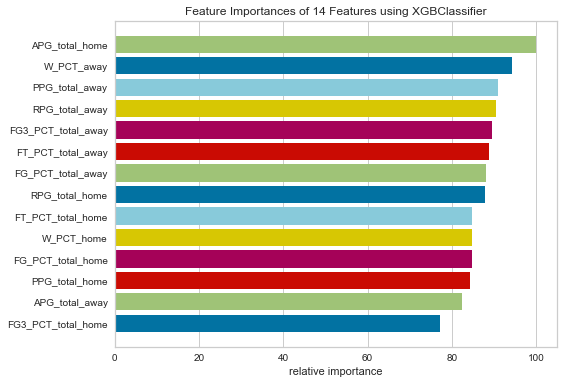

---------------------------------------------
i=2
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 19}): 0.52
              precision    recall  f1-score   support

           0       0.69      0.08      0.14      2727
           1       0.51      0.97      0.67      2757

    accuracy                           0.52      5484
   macro avg       0.60      0.52      0.40      5484
weighted avg       0.60      0.52      0.40      5484



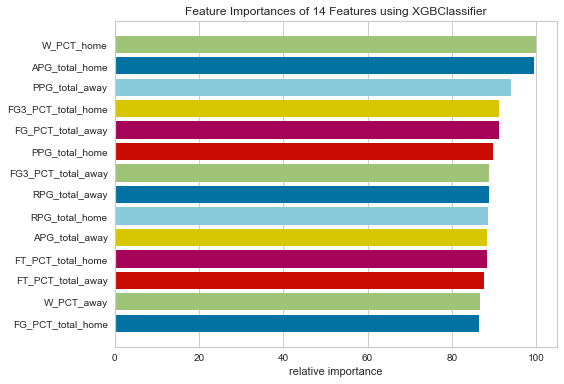

---------------------------------------------
i=3
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2715
           1       0.00      0.00      0.00      2768

    accuracy                           0.50      5483
   macro avg       0.25      0.50      0.33      5483
weighted avg       0.25      0.50      0.33      5483



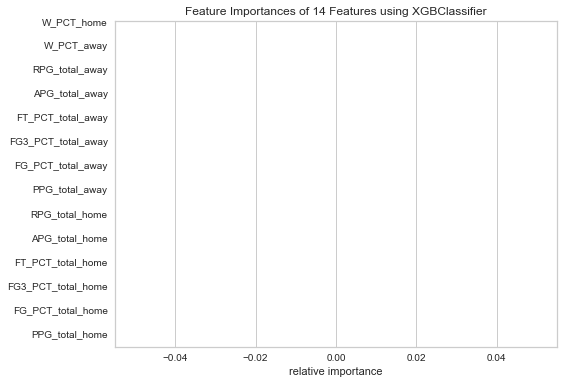

---------------------------------------------
i=4
WINNER:

Best XGBoost accuracy ({'scale_pos_weight': 20}): 0.51
              precision    recall  f1-score   support

           0       0.72      0.06      0.12      2792
           1       0.50      0.97      0.66      2691

    accuracy                           0.51      5483
   macro avg       0.61      0.52      0.39      5483
weighted avg       0.61      0.51      0.39      5483



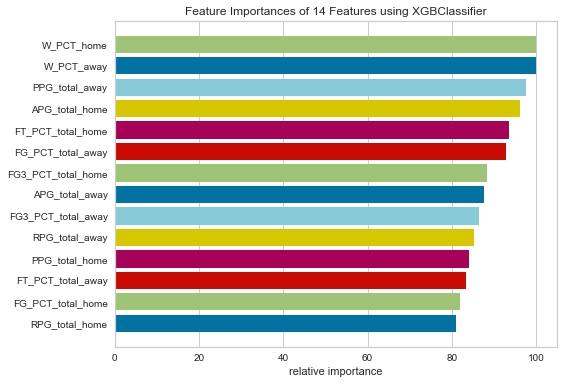

---------------------------------------------
Mean accuracy: 0.5162516031582532
Max accuracy: 0.5306345733041575
Min accuracy: 0.495166879445559
i=5
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.51
              precision    recall  f1-score   support

           0       0.51      1.00      0.68      2614
           1       0.00      0.00      0.00      2495

    accuracy                           0.51      5109
   macro avg       0.26      0.50      0.34      5109
weighted avg       0.26      0.51      0.35      5109



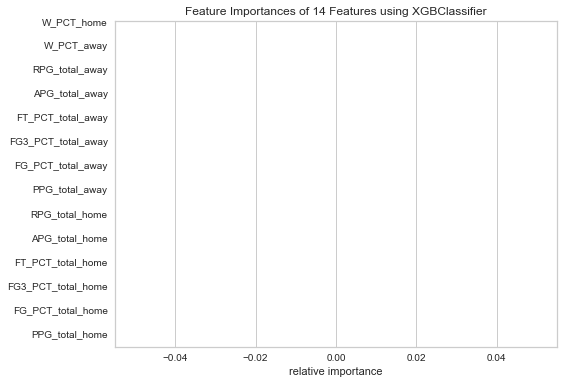

---------------------------------------------
i=6
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 23}): 0.51
              precision    recall  f1-score   support

           0       0.62      0.05      0.10      2571
           1       0.50      0.97      0.66      2538

    accuracy                           0.51      5109
   macro avg       0.56      0.51      0.38      5109
weighted avg       0.56      0.51      0.38      5109



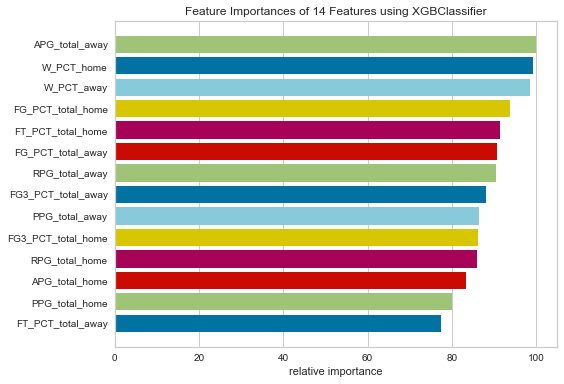

---------------------------------------------
i=7
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2559
           1       0.00      0.00      0.00      2549

    accuracy                           0.50      5108
   macro avg       0.25      0.50      0.33      5108
weighted avg       0.25      0.50      0.33      5108



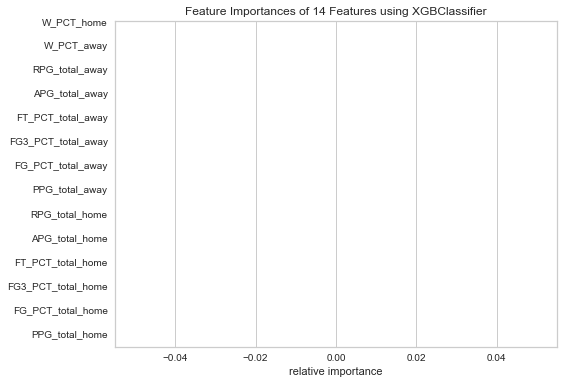

---------------------------------------------
i=8
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.48
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      2470
           1       0.00      0.00      0.00      2638

    accuracy                           0.48      5108
   macro avg       0.24      0.50      0.33      5108
weighted avg       0.23      0.48      0.32      5108



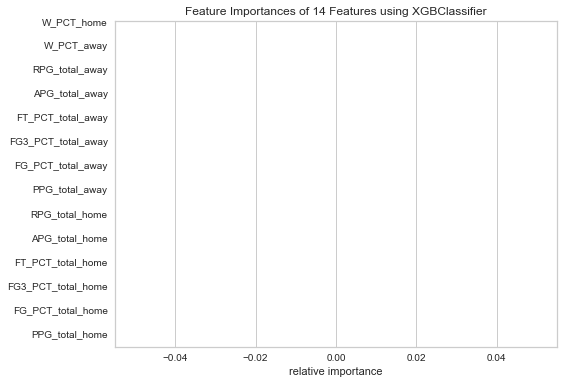

---------------------------------------------
i=9
FGP:

Best XGBoost accuracy ({'scale_pos_weight': 26}): 0.52
              precision    recall  f1-score   support

           0       0.73      0.05      0.10      2557
           1       0.51      0.98      0.67      2551

    accuracy                           0.52      5108
   macro avg       0.62      0.52      0.38      5108
weighted avg       0.62      0.52      0.38      5108



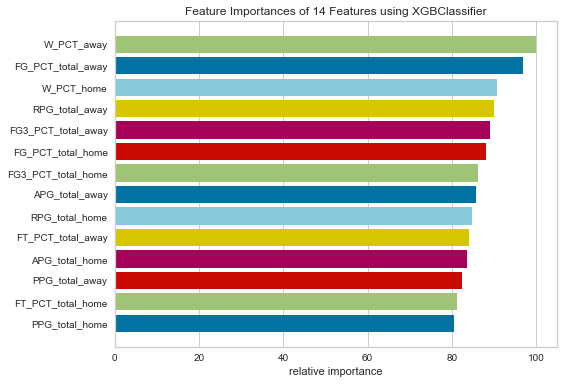

---------------------------------------------
Mean accuracy: 0.5009779083022222
Max accuracy: 0.5116461146995498
Min accuracy: 0.48355520751761943
i=10
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 5}): 0.51
              precision    recall  f1-score   support

           0       0.59      0.07      0.12      2365
           1       0.50      0.95      0.66      2346

    accuracy                           0.51      4711
   macro avg       0.55      0.51      0.39      4711
weighted avg       0.55      0.51      0.39      4711



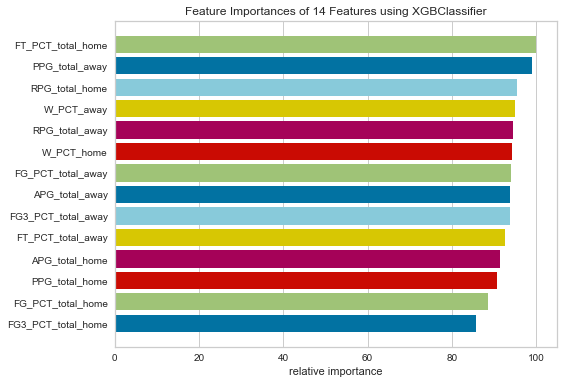

---------------------------------------------
i=11
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 19}): 0.49
              precision    recall  f1-score   support

           0       0.52      0.04      0.08      2402
           1       0.49      0.96      0.65      2309

    accuracy                           0.49      4711
   macro avg       0.50      0.50      0.36      4711
weighted avg       0.50      0.49      0.36      4711



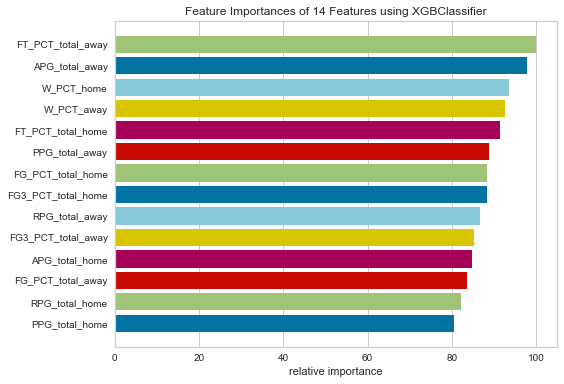

---------------------------------------------
i=12
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 10}): 0.51
              precision    recall  f1-score   support

           0       0.49      0.05      0.09      2284
           1       0.52      0.95      0.67      2427

    accuracy                           0.51      4711
   macro avg       0.50      0.50      0.38      4711
weighted avg       0.50      0.51      0.39      4711



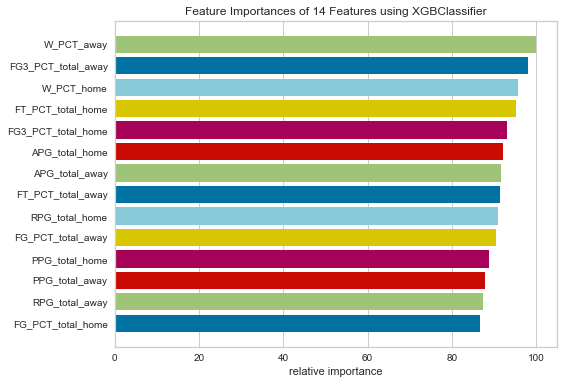

---------------------------------------------
i=13
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 25}): 0.51
              precision    recall  f1-score   support

           0       0.57      0.04      0.07      2307
           1       0.51      0.97      0.67      2404

    accuracy                           0.51      4711
   macro avg       0.54      0.51      0.37      4711
weighted avg       0.54      0.51      0.38      4711



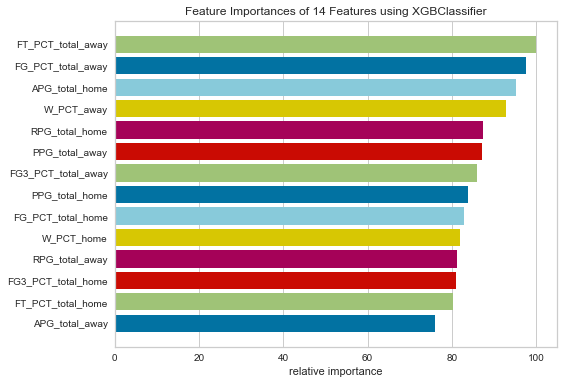

---------------------------------------------
i=14
FG3:

Best XGBoost accuracy ({'scale_pos_weight': 21}): 0.49
              precision    recall  f1-score   support

           0       0.60      0.04      0.07      2419
           1       0.49      0.97      0.65      2291

    accuracy                           0.49      4710
   macro avg       0.54      0.51      0.36      4710
weighted avg       0.54      0.49      0.35      4710



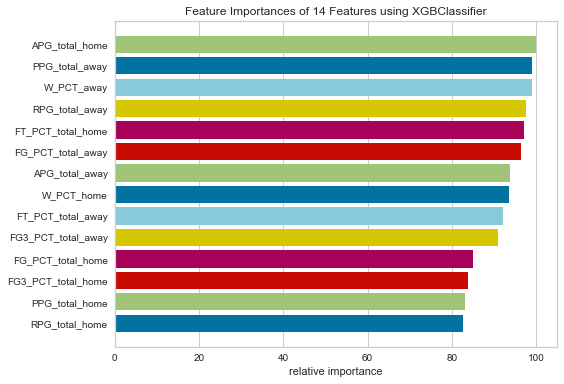

---------------------------------------------
Mean accuracy: 0.507270218637232
Max accuracy: 0.5147527064317554
Min accuracy: 0.49140309912969643
i=15
FT:

Best XGBoost accuracy ({'scale_pos_weight': 1}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.52      0.52      2337
           1       0.53      0.54      0.53      2345

    accuracy                           0.53      4682
   macro avg       0.53      0.53      0.53      4682
weighted avg       0.53      0.53      0.53      4682



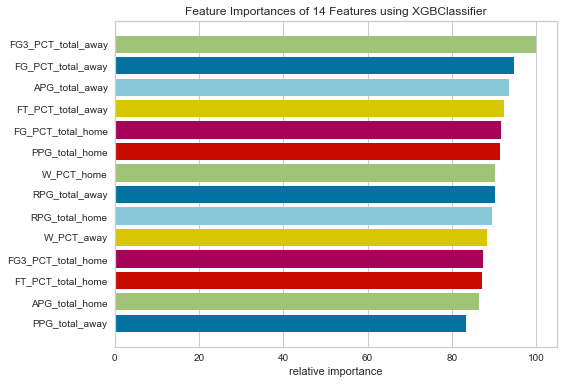

---------------------------------------------
i=16
FT:

Best XGBoost accuracy ({'scale_pos_weight': 12}): 0.51
              precision    recall  f1-score   support

           0       0.56      0.05      0.10      2322
           1       0.51      0.96      0.66      2360

    accuracy                           0.51      4682
   macro avg       0.53      0.51      0.38      4682
weighted avg       0.53      0.51      0.38      4682



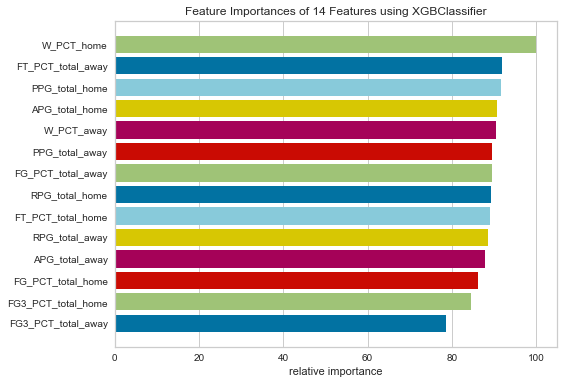

---------------------------------------------
i=17
FT:

Best XGBoost accuracy ({'scale_pos_weight': 18}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.04      0.07      2360
           1       0.50      0.96      0.65      2322

    accuracy                           0.50      4682
   macro avg       0.49      0.50      0.36      4682
weighted avg       0.49      0.50      0.36      4682



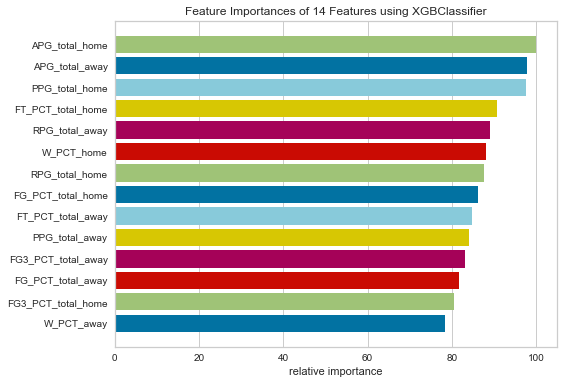

---------------------------------------------
i=18
FT:

Best XGBoost accuracy ({'scale_pos_weight': 14}): 0.50
              precision    recall  f1-score   support

           0       0.53      0.04      0.08      2343
           1       0.50      0.96      0.66      2339

    accuracy                           0.50      4682
   macro avg       0.51      0.50      0.37      4682
weighted avg       0.51      0.50      0.37      4682



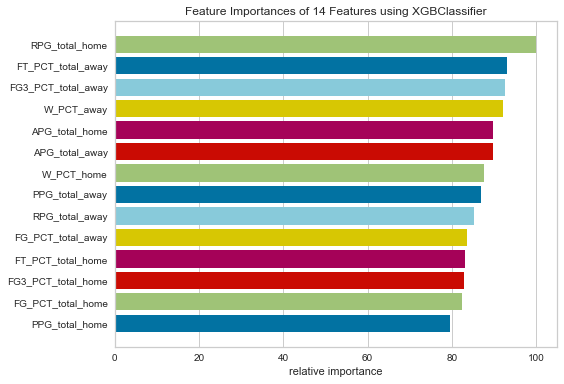

---------------------------------------------
i=19
FT:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2343
           1       0.00      0.00      0.00      2339

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



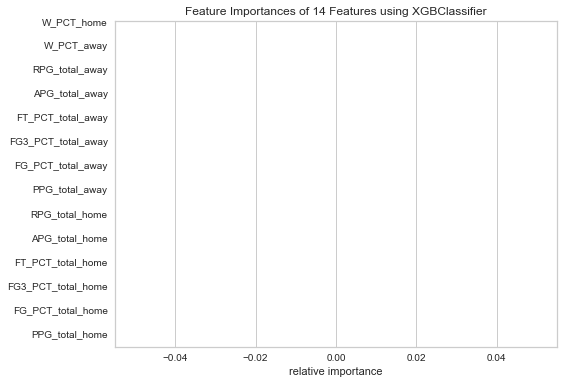

---------------------------------------------
Mean accuracy: 0.508489961554891
Max accuracy: 0.5271251601879539
Min accuracy: 0.49530115335326785
i=20
AST:

Best XGBoost accuracy ({'scale_pos_weight': 16}): 0.52
              precision    recall  f1-score   support

           0       0.77      0.07      0.13      2556
           1       0.51      0.98      0.67      2540

    accuracy                           0.52      5096
   macro avg       0.64      0.52      0.40      5096
weighted avg       0.64      0.52      0.40      5096



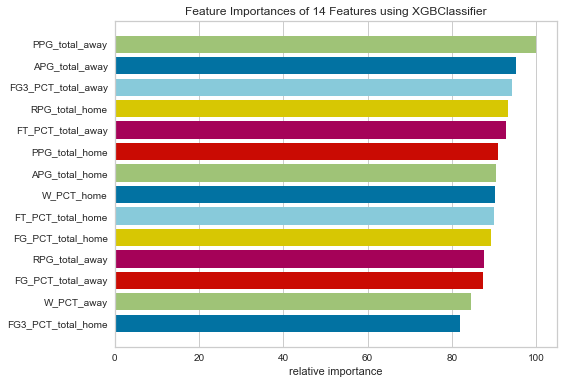

---------------------------------------------
i=21
AST:

Best XGBoost accuracy ({'scale_pos_weight': 27}): 0.50
              precision    recall  f1-score   support

           0       0.58      0.04      0.07      2578
           1       0.50      0.97      0.66      2517

    accuracy                           0.50      5095
   macro avg       0.54      0.50      0.36      5095
weighted avg       0.54      0.50      0.36      5095



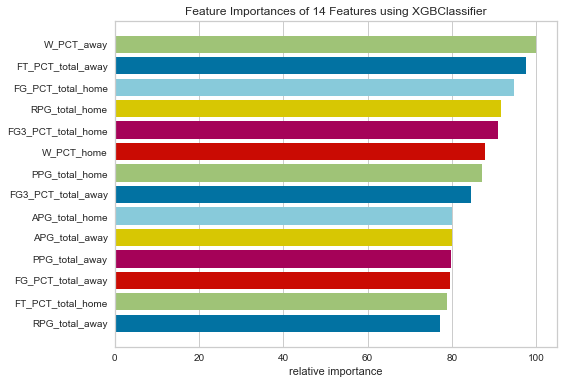

---------------------------------------------
i=22
AST:

Best XGBoost accuracy ({'scale_pos_weight': 22}): 0.52
              precision    recall  f1-score   support

           0       0.67      0.05      0.10      2522
           1       0.51      0.97      0.67      2573

    accuracy                           0.52      5095
   macro avg       0.59      0.51      0.39      5095
weighted avg       0.59      0.52      0.39      5095



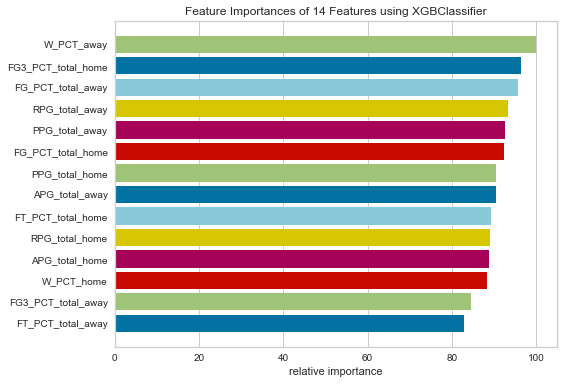

---------------------------------------------
i=23
AST:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2531
           1       0.00      0.00      0.00      2564

    accuracy                           0.50      5095
   macro avg       0.25      0.50      0.33      5095
weighted avg       0.25      0.50      0.33      5095



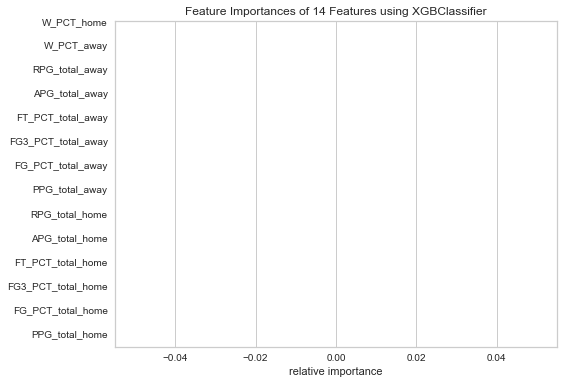

---------------------------------------------
i=24
AST:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2551
           1       0.00      0.00      0.00      2544

    accuracy                           0.50      5095
   macro avg       0.25      0.50      0.33      5095
weighted avg       0.25      0.50      0.33      5095



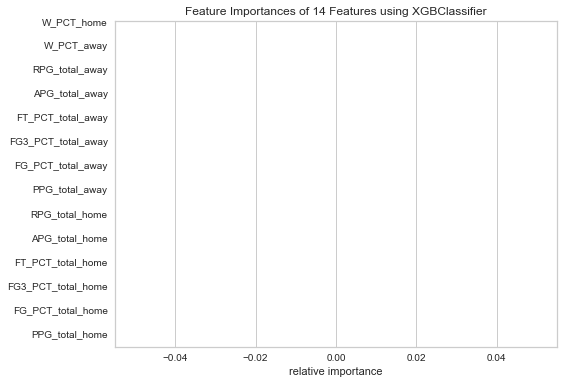

---------------------------------------------
Mean accuracy: 0.5093953405699866
Max accuracy: 0.5229591836734694
Min accuracy: 0.49676153091265945
i=25
REB:

Best XGBoost accuracy ({'scale_pos_weight': 26}): 0.50
              precision    recall  f1-score   support

           0       0.55      0.04      0.08      2470
           1       0.50      0.97      0.66      2475

    accuracy                           0.50      4945
   macro avg       0.52      0.50      0.37      4945
weighted avg       0.52      0.50      0.37      4945



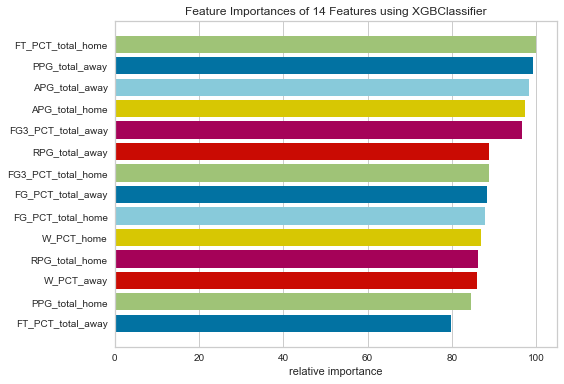

---------------------------------------------
i=26
REB:

Best XGBoost accuracy ({'scale_pos_weight': 19}): 0.52
              precision    recall  f1-score   support

           0       0.65      0.05      0.10      2413
           1       0.52      0.97      0.68      2532

    accuracy                           0.52      4945
   macro avg       0.58      0.51      0.39      4945
weighted avg       0.58      0.52      0.39      4945



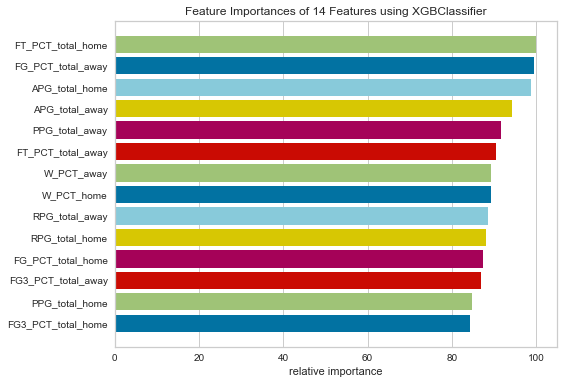

---------------------------------------------
i=27
REB:

Best XGBoost accuracy ({'scale_pos_weight': 26}): 0.51
              precision    recall  f1-score   support

           0       0.62      0.05      0.09      2479
           1       0.50      0.97      0.66      2465

    accuracy                           0.51      4944
   macro avg       0.56      0.51      0.38      4944
weighted avg       0.56      0.51      0.38      4944



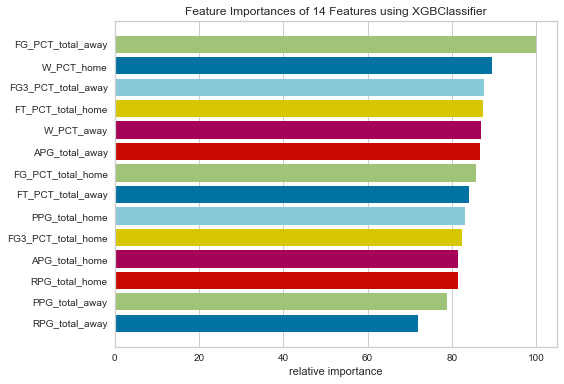

---------------------------------------------
i=28
REB:

Best XGBoost accuracy ({'scale_pos_weight': 0}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2473
           1       0.00      0.00      0.00      2471

    accuracy                           0.50      4944
   macro avg       0.25      0.50      0.33      4944
weighted avg       0.25      0.50      0.33      4944



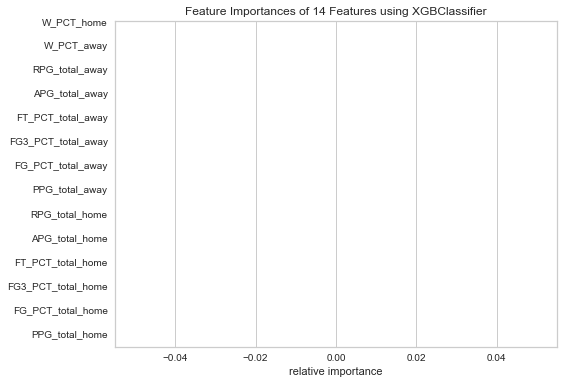

---------------------------------------------
i=29
REB:

Best XGBoost accuracy ({'scale_pos_weight': 27}): 0.50
              precision    recall  f1-score   support

           0       0.68      0.05      0.09      2526
           1       0.50      0.98      0.66      2418

    accuracy                           0.50      4944
   macro avg       0.59      0.51      0.37      4944
weighted avg       0.59      0.50      0.37      4944



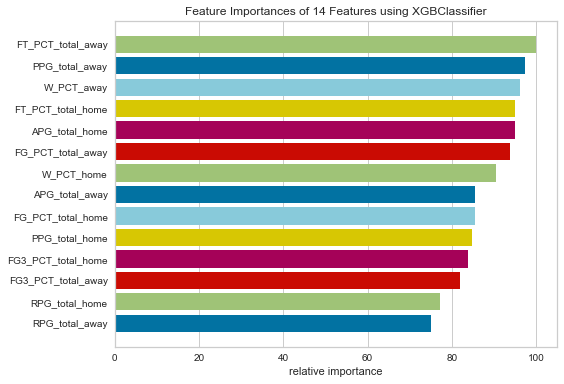

---------------------------------------------
Mean accuracy: 0.5089488417904391
Max accuracy: 0.5235591506572296
Min accuracy: 0.5002022653721683


In [29]:
# Control the balance of positive and negative weights, useful for unbalanced classes. 
# A typical value to consider: sum(negative instances) / sum(positive instances).

print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'scale_pos_weight' : [*range(0,30)],
})